# <center> Тестовое задание Wheely</center>

**Задание 1** Кейс Представьте, что компания Wheely решает запустить свой бизнес в новом городе. Цель – в годовой перспективе максимально дифференцироваться на рынке как лучший премиальный продукт и набрать базу лояльных пользователей. Вас, как аналитика, просят определить ключевые метрики для достижения этой цели и пороговые значения, которые будут говорить нам о том, что мы достигли успеха. Какими будет ваши предложения?


**Задание 2** Перед вами стоит задача кластеризовать/сегментировать активных B2C пользователей Wheely, чтобы полученные сегменты можно было использовать для оптимизации таргетинговой рекламы. Проведите полноценный анализ и презентуйте свое решение.

In [1]:
from __future__ import (absolute_import, division,print_function, unicode_literals)
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
%pylab inline
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm 
import pickle

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score

Populating the interactive namespace from numpy and matplotlib


###  Часть 1. Описание набора данных и признаков

In [2]:
data = pd.read_csv('orders.csv',na_values="NaN")
data.head()

_id     user_id             completed_at  duration  distance  price  \
0  ec4c725f62  b14de8a940  2017-01-01 00:11:54.000     508.0    3613.0  498.0   
1  8ad53f1e52  9f563f3b47  2017-01-01 00:24:39.000       0.0       0.0    0.0   
2  f39c8f74a7  e43cc45c19  2017-01-01 00:25:06.000    1119.0    5449.0  726.0   
3  3a9852ced0  7a50190eaf  2017-01-01 01:02:33.000       0.0       0.0    0.0   
4  0f44dc5848  19dc69f7f3  2017-01-01 01:36:27.000     659.0    6856.0    0.0   

   credit  to_pay   vendor_id         dropoff          pickup     status  \
0     0.0     0.0  d2371067ea             NaN  street_address       done   
1     0.0     0.0  e2a2d88896             NaN             NaN  cancelled   
2     0.0     0.0  d2371067ea             NaN  street_address       done   
3     0.0     0.0  e2a2d88896             NaN  street_address  cancelled   
4     0.0     0.0  e2a2d88896  street_address  street_address  cancelled   

  payment_type  
0         card  
1         card  
2         card  
3         card  
4         card

In [3]:
data['vendor_id'].replace('25ba3f0e07', 'C', inplace=True)
data['vendor_id'].replace('e2a2d88896', 'B', inplace=True)
data['vendor_id'].replace('d2371067ea', 'A', inplace=True)

In [4]:
users = pd.read_csv('users.csv',na_values="NaN")
users.head()

_id utm_medium  app__os
0  de974bbd30    organic      iOS
1  6e38b78ef6     invite      iOS
2  5655d8485c        NaN  android
3  ab0c976846     invite  android
4  69be64a10f     invite      iOS

### Часть 2. Первичный анализ признаков

Посмотрим есть ли nan / пропуски значения, типы признаков и сколько датасет занимает в памяти

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70375 entries, 0 to 70374
Data columns (total 13 columns):
_id             70375 non-null object
user_id         70375 non-null object
completed_at    70375 non-null object
duration        70224 non-null float64
distance        70224 non-null float64
price           70224 non-null float64
credit          70375 non-null float64
to_pay          70375 non-null float64
vendor_id       70375 non-null object
dropoff         31093 non-null object
pickup          69787 non-null object
status          70375 non-null object
payment_type    70375 non-null object
dtypes: float64(5), object(8)
memory usage: 4.8+ MB


Время окончания заказа completed_at приведем к формату Datetime

In [6]:
data['completed_at']=data['completed_at'].apply (lambda x : pd.to_datetime(x))   
cat_features=data.select_dtypes(include=['object']).columns.values.tolist()
real_features=data.select_dtypes(include=['float64','int64']).columns.values.tolist()

In [7]:
data[real_features].describe(include='all').T

count         mean           std   min     25%     50%     75%  \
duration  70224.0  1437.735632   2713.562447 -23.0   593.0   980.0  1578.0   
distance  70224.0  9138.558171  30199.662461   0.0  2649.0  5047.0  9256.0   
price     70224.0   358.786626   1024.742713   0.0   163.0   252.0   395.0   
credit    70375.0    11.543758     53.440172   0.0     0.0     0.0     0.0   
to_pay    70375.0     9.723865    803.213713   0.0     0.0     0.0     0.0   

                max  
duration   190887.0  
distance  3957741.0  
price      102070.0  
credit        900.0  
to_pay     101971.0

Продолжительность заказа (секунды) - duration меньше нуля заменим при дальнейшей обработке на ноль

In [8]:
data['duration'][data['duration']<0]

25957   -23.0
60507   -11.0
Name: duration, dtype: float64

In [9]:
data[real_features].median()

duration     980.0
distance    5047.0
price        252.0
credit         0.0
to_pay         0.0
dtype: float64

Такая разница между средним и медианой говорит о сильной концентрации  у определенных значений

In [10]:
data[cat_features].describe(include='all').T

count unique             top   freq
_id           70375  70375      dfca9afdf9      1
user_id       70375   5599      cdff81c9ed    958
vendor_id     70375      3               B  45615
dropoff       31093     16  street_address  20649
pickup        69787     15  street_address  58048
status        70375      4            done  62453
payment_type  70375      3            card  51168

In [11]:
data['completed_at'].describe(include='all').T

count                   70375
unique                  70216
top       2017-04-03 10:43:34
freq                        2
first     2017-01-01 00:07:25
last      2017-07-10 02:36:51
Name: completed_at, dtype: object

На этапе первичного анализа признаков наиболее интересны столбцы min и max, чобы посмотреть в каких признаках могут быть сильные выбросы. На текущий момент нужно дополнительно проанализировать следующие признаки на предмет выбросов
Удалять выбросы будем после первичного визуального анализа признаков

In [12]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5599 entries, 0 to 5598
Data columns (total 3 columns):
_id           5599 non-null object
utm_medium    5557 non-null object
app__os       5536 non-null object
dtypes: object(3)
memory usage: 65.7+ KB


In [13]:
users.describe(include='all').T

count unique         top  freq
_id         5599   5599  c5425408f9     1
utm_medium  5557     12      invite  3073
app__os     5536      4         iOS  3818

###  Часть 3. Первичный визуальный анализ признаков

**Данные транзакций**

Расмотрим первоначально переменную  completed_at - Время окончания заказа. Преобразуем переменную  числовую - время и категорианую переменную - день недели

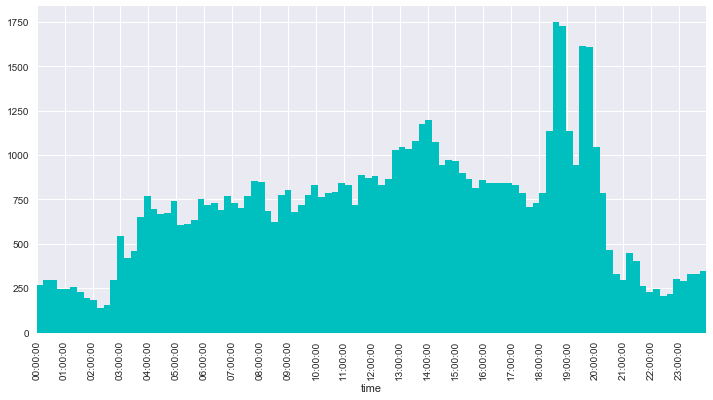

In [14]:
data['time']=data['completed_at'].apply (lambda x : x.time())  
data['time'].hist(figsize=(12, 6),bins=100,color='c');
xmarks= pd.date_range("00:00", "23:59", freq="60min").time
plt.xticks(xmarks, rotation=90)
plt.xlim ("00:00", "23:59");

In [15]:
data['time']=data['time'].map(lambda x: x.hour*100+ x.minute) #  x.minute//30*30 кратно 30 минутам
data['time'].head()

0     11
1     24
2     25
3    102
4    136
Name: time, dtype: int64

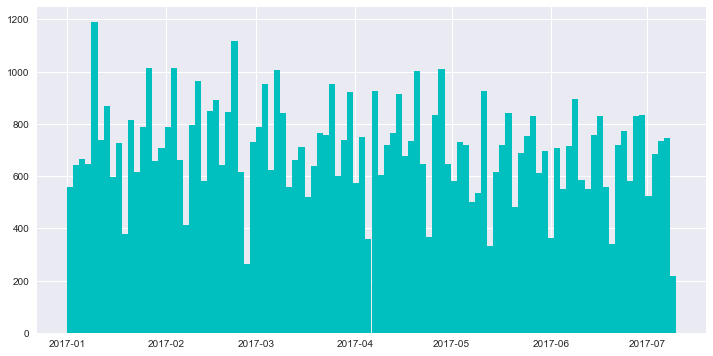

In [16]:
data['day']=data['completed_at'].apply (lambda x : x.date())  
data['day'].hist(figsize=(12, 6),bins=100,color='c');

Посмотрим как распределены транзакции на январские и майские праздники. Заметен всплеск в понедельник при возвращении с январских праздников

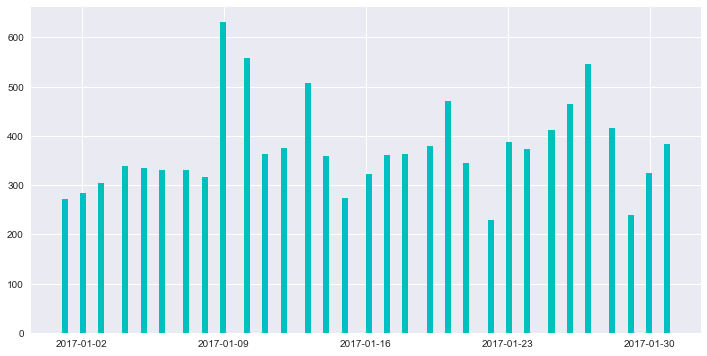

In [17]:
first_holiday=data['day'] <= datetime.date(2017, 1, 31)
data['day'].loc[first_holiday].hist(figsize=(12, 6),bins=100,color='c');

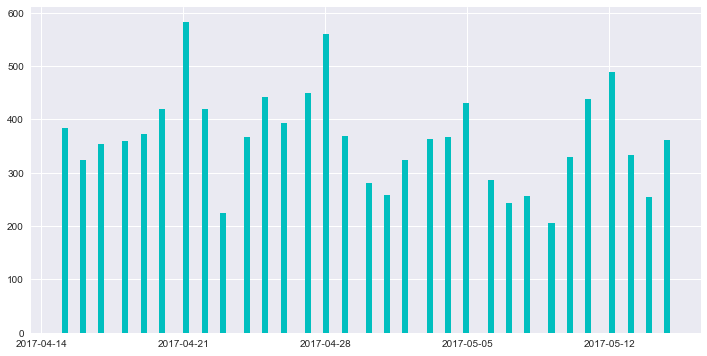

In [18]:
second_holiday=(data['day'] >= datetime.date(2017, 4, 15)) & (data['day'] <= datetime.date(2017, 5, 15))
data['day'].loc[second_holiday].hist(figsize=(12, 6),bins=100,color='c');

Расспределение по дням недели

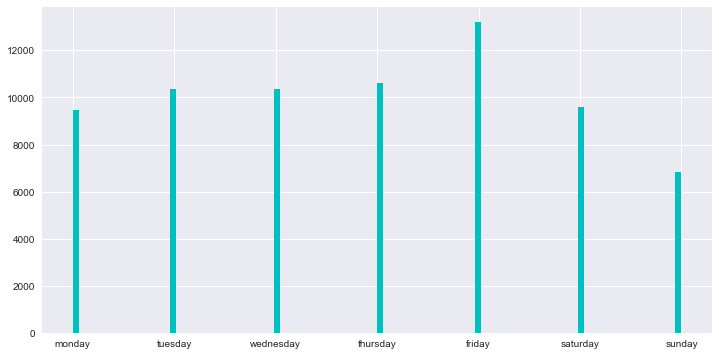

In [19]:
DayOfWeek =["monday","tuesday","wednesday","thursday","friday","saturday","sunday"]
data['dayOfWeek']=data['completed_at'].apply (lambda x : x.weekday()) 
data['dayOfWeek'].hist(figsize=(12, 6),bins=100,color='c');
plt.xticks(range(0,7), DayOfWeek );

Также сделаем день недели как категориальную переменную чтобы убрать порядок из признака

In [20]:
# The day of the week with Monday=0, Sunday=6
data['dayOfWeek_cat']=data['completed_at'].apply (lambda x : DayOfWeek[x.weekday()])   

In [21]:
data['dayOfWeek_cat'].value_counts()

friday       13200
thursday     10607
tuesday      10357
wednesday    10340
saturday      9578
monday        9474
sunday        6819
Name: dayOfWeek_cat, dtype: int64

Перепишем разделение признаков на числовые и категориальные

In [22]:
cat_features=data.select_dtypes(include=['object']).columns.values.tolist()
real_features=data.select_dtypes(include=['float64','int64']).columns.values.tolist()

Посмотрим как распределены значения категориальных признаков 

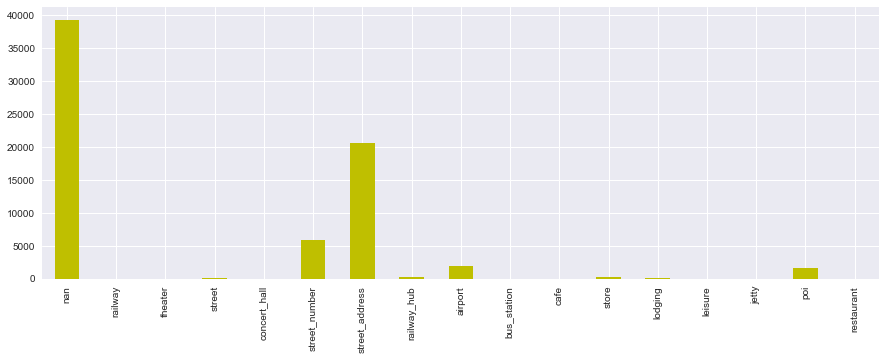

In [23]:
# показано с учетом пропусков
data['dropoff'].value_counts(sort=False,dropna=False).plot(kind='bar',figsize=(15, 5),color='y');

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 14.69it/s]


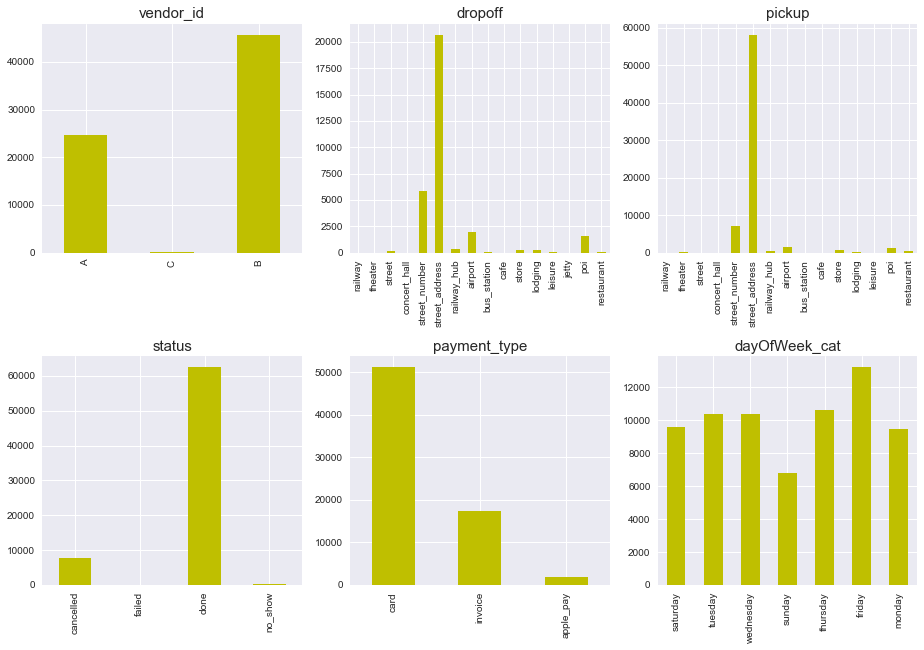

In [24]:
from tqdm import tqdm 
k=1
for features in tqdm(data[cat_features].columns):
    plt.figure(1,figsize=(13,13))    
    plt.subplot(3,3,k)
    if len(set(data[features])) < 100:
        data[features].value_counts(sort=False).plot(kind='bar',color='y');
        plt.title(features,fontdict={'fontsize':15}) 
        k+=1
plt.tight_layout() 
plt.show()

Обратим внимание наличие бинарных категориальных признаков, т.е. категориальных признаков с 2-3 уникальными значениями -> vendor_id, payment_type

**Данные о пользователях**

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 11.43it/s]


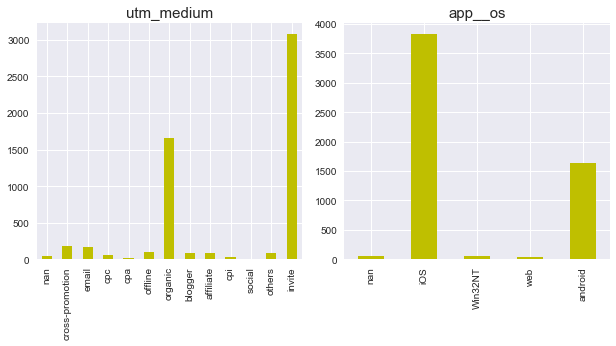

In [25]:
# показано с учетом пропусков
k=1
for features in tqdm(users[['utm_medium','app__os']].columns):
    plt.figure(1,figsize=(13,13))    
    plt.subplot(3,3,k)
    if len(set(users[features])) < 100:
        users[features].value_counts(sort=False,dropna=False).plot(kind='bar',color='y');
        plt.title(features,fontdict={'fontsize':15}) 
        k+=1
plt.tight_layout() 
plt.show()

Рассмотрим распределение числовых признаков набора данных о транзакциях

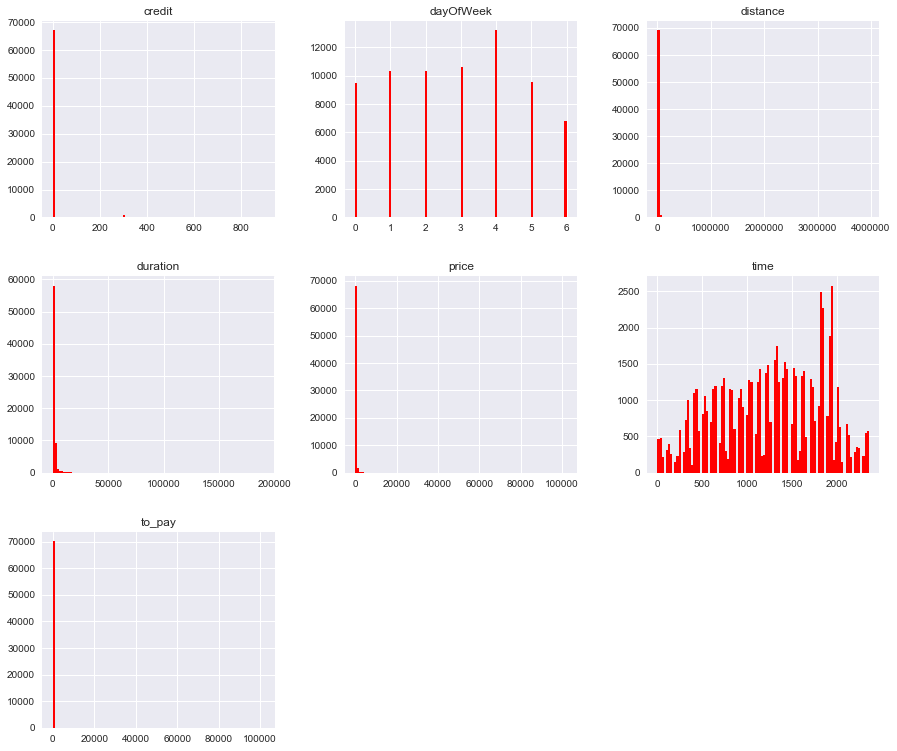

In [26]:
data[real_features].hist(figsize=(15, 13),bins=100,color='r');

Поскольку визуализация выше недостаточно информативна, прологаримируем количественные признаки

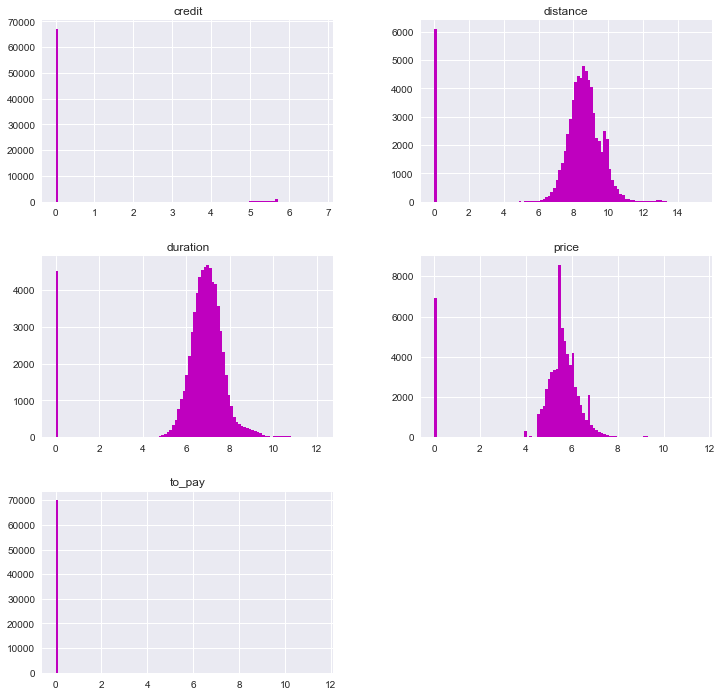

In [27]:
# без real_features[:-2] без 'time', 'dayOfWeek'
data[real_features[:-2]].applymap(lambda x: np.log1p(x)).hist(figsize=(12, 12),bins=100,color='m');

###  Часть 4. Предобработка данных - числовых / категориальных признаков

In [28]:
data['dropoff'].fillna('secret',inplace=True)
data['pickup'].fillna('secret',inplace=True)
data['duration']  = data['duration'].apply(lambda x: 0 if x<=0 else x)

Обработаем пропуски в признаках duration / distance / price. Обращает внимание что значение признака status  = failed полностью приходится на пропуски по этим признакам. Заменим пропуски на нули, а значения failed признака status на cancelled

In [29]:
data[data['duration'].isnull()].head()

_id     user_id        completed_at  duration  distance  price  \
126   c953e016d9  e004197423 2017-01-02 12:59:53       NaN       NaN    NaN   
153   cab67af6a8  4d602db338 2017-01-02 19:53:37       NaN       NaN    NaN   
252   b723079f65  2d892145b0 2017-01-03 06:27:42       NaN       NaN    NaN   
1099  464893910f  239a139663 2017-01-08 18:51:40       NaN       NaN    NaN   
2744  2e5aa899cd  90bf8936c0 2017-01-16 16:29:31       NaN       NaN    NaN   

      credit  to_pay vendor_id         dropoff          pickup     status  \
126      0.0     0.0         A   street_number          secret     failed   
153      0.0     0.0         B          secret   street_number     failed   
252      0.0     0.0         B          secret  street_address     failed   
1099     0.0     0.0         B  street_address  street_address  cancelled   
2744     0.0     0.0         B  street_address  street_address     failed   

     payment_type  time         day  dayOfWeek dayOfWeek_cat  
126          card  1259  2017-01-02          0        monday  
153       invoice  1953  2017-01-02          0        monday  
252          card   627  2017-01-03          1       tuesday  
1099         card  1851  2017-01-08          6        sunday  
2744         card  1629  2017-01-16          0        monday

In [30]:
data['status'][data['duration'].isnull()].value_counts()

failed       109
cancelled     41
done           1
Name: status, dtype: int64

In [31]:
data['status'].value_counts()

done         62453
cancelled     7649
no_show        164
failed         109
Name: status, dtype: int64

In [32]:
data['duration']  = data['duration'].apply(lambda x: 0 if pd.isnull(x) else x)
data['distance']  = data['distance'].apply(lambda x: 0 if pd.isnull(x) else x)
data['price']  = data['price'].apply(lambda x: 0 if pd.isnull(x) else x)
data['status'].replace('failed', 'cancelled', inplace=True)

In [33]:
# данные о пользователях
users['utm_medium'].fillna('unknown',inplace=True)
users['app__os'].fillna('unknown',inplace=True)

###  Часть 5. Парный визуальный анализ числовых / категориальных признаков

Визуализируем числовые признаки попарно. Построим scatterplot для пар вещественных признаков. Указать параметр hue = категориальный  признак, то разные его значения будут отображаться разными цветами. Удалим пропуски поскольку pairplot не работает с пропусками

Wall time: 30.9 s


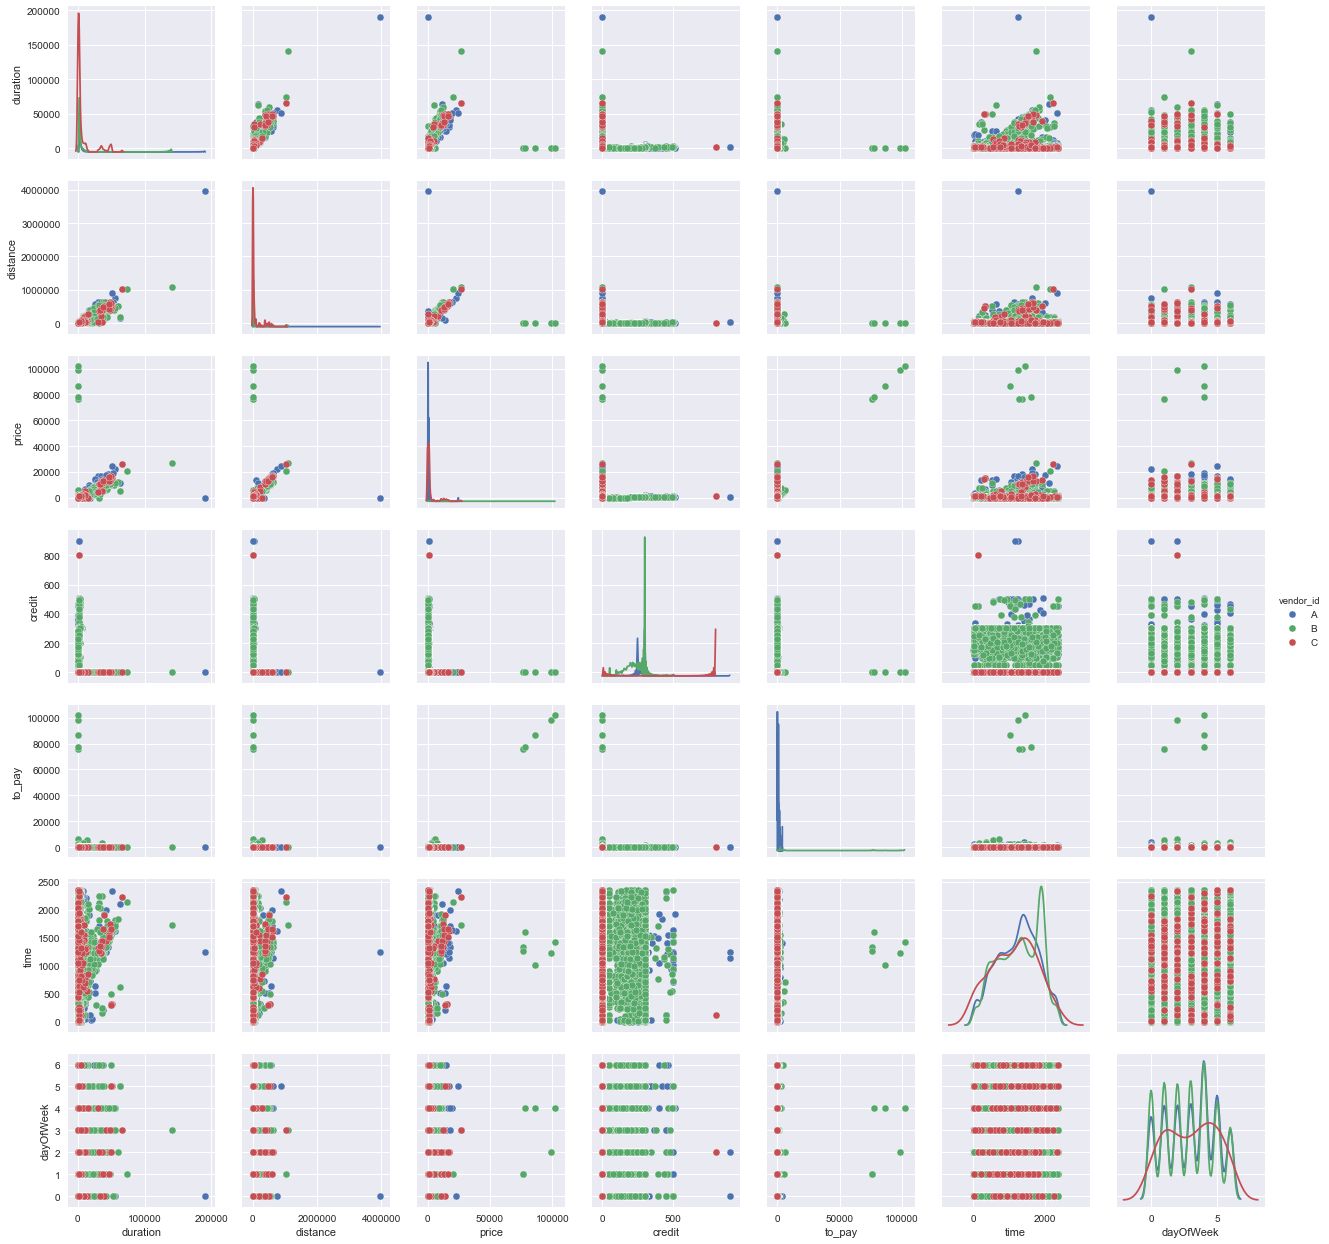

In [34]:
%%time
data_pairplot=pd.concat([data[real_features],data['vendor_id']], axis=1)
data_pairplot.dropna(inplace=True)
sns.pairplot(data_pairplot,diag_kind="kde",hue='vendor_id');

Wall time: 29.7 s


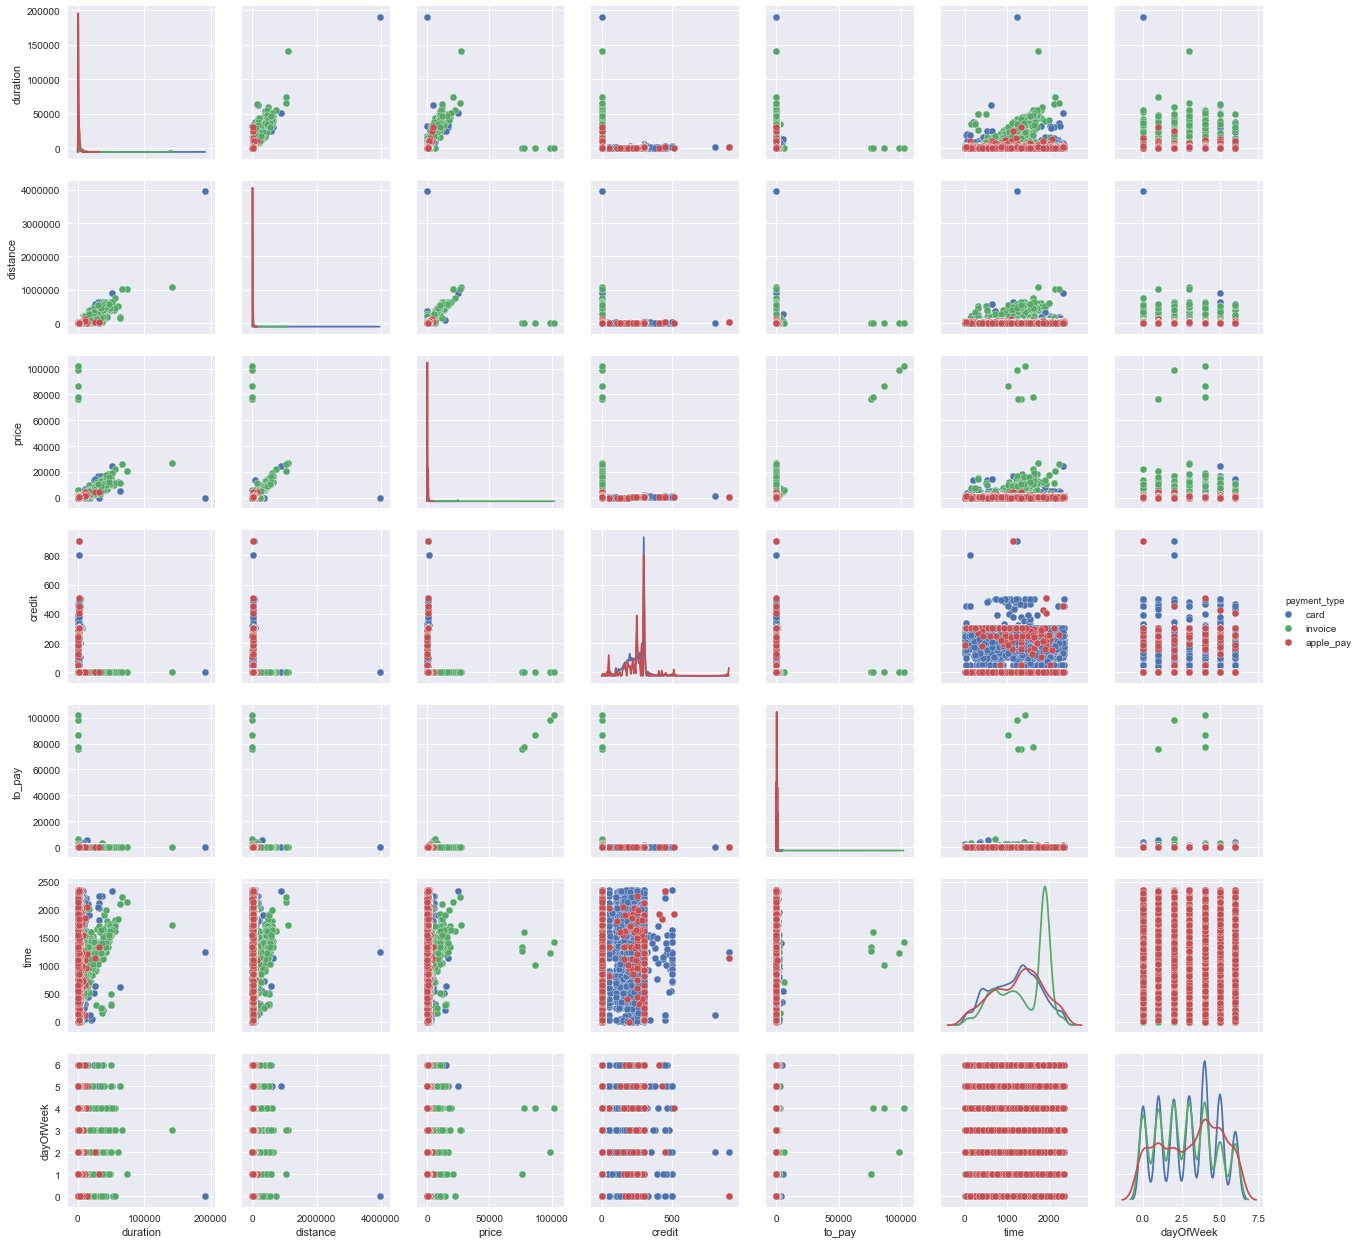

In [35]:
%%time
data_pairplot=pd.concat([data[real_features],data['payment_type']], axis=1)
data_pairplot.dropna(inplace=True)
sns.pairplot(data_pairplot,diag_kind="kde",hue='payment_type');

Следует понимать, что pairplot закрашивает область распределения значений последовательно, и последнее значение целевой в переменной будет в 'верхнем слое' рисунка закрашивая собой остальные предшествующие значения целеых переменных у объектов. Рассмотрим попарные распределения некоторых признаков более крупно

In [36]:
from matplotlib.colors import ListedColormap
colors=ListedColormap(['b','g'])
def scatter_def(x1,x2,hue):
    sns.pairplot(data,x_vars=[x1],y_vars=[x2],size=5, hue=hue);

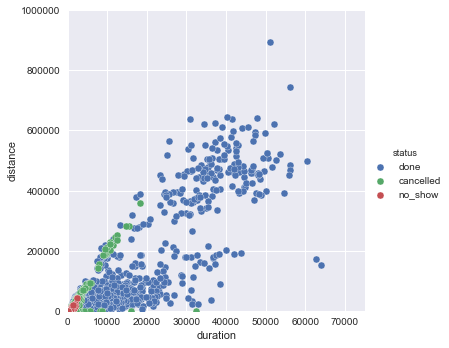

In [37]:
scatter_def('duration','distance','status')
plt.xlim(0,75000)
plt.ylim(0,1000000);

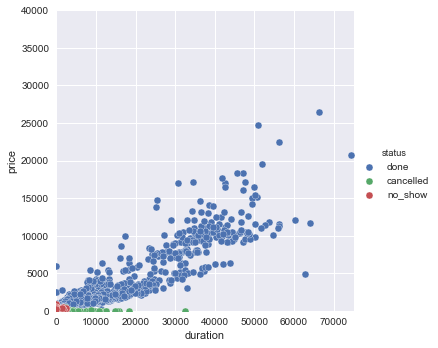

In [38]:
scatter_def('duration','price','status')
plt.xlim(0,75000)
plt.ylim(0,40000);

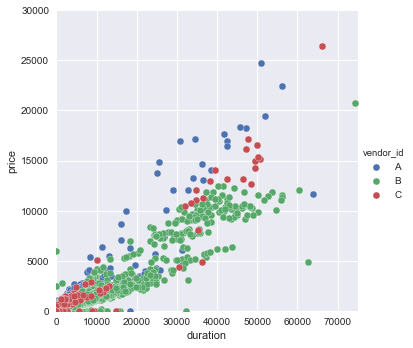

In [39]:
scatter_def('duration','price','vendor_id')
plt.xlim(0,75000)
plt.ylim(0,30000);

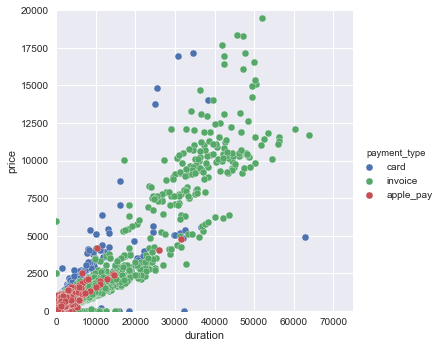

In [40]:
scatter_def('duration','price','payment_type')
plt.xlim(0,75000)
plt.ylim(0,20000) ;

Корреляция между числовыми признаками

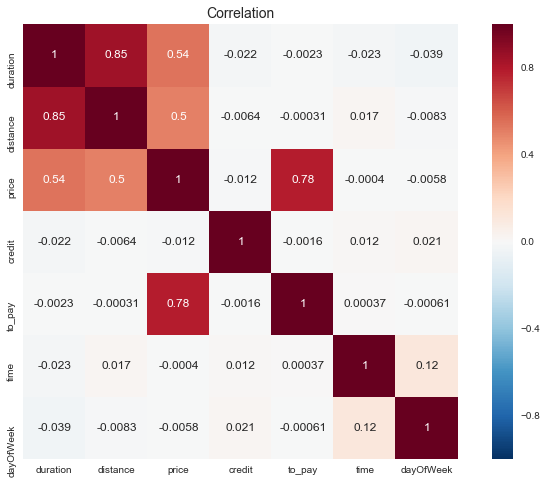

In [41]:
plt.figure(figsize=(12, 8))
plt.title('Correlation',fontsize=14);
# square=True делает квадратной
sns.heatmap(data[real_features].corr(),square=True,cbar=True,cmap='RdBu_r',annot=True); # _r значит реверсная карта в цветах

Посмотрим теперь попарные распределения категориальных признаков

In [30]:
def cat_imshow(x,y,data):
    crosstab_fd=pd.crosstab(data[y], data[x])
    # применили ко всей таблице сопряженности логаримф чтобы лучше отобразить imshow, 
    # иначе большая разница между мин и макс
    crosstab_fd_log=crosstab_fd.applymap(lambda x: 0 if x==0 else log(x))
    plt.figure( figsize=(5,5))
    plt.imshow(crosstab_fd_log,cmap='seismic',interpolation='none');
    unique_x, unique_y = set(data[x]),set(data[y])
    plt.yticks(range(len(unique_y)),[n for n in sorted(unique_y)]) # сохраняем порядок
    plt.xticks(range(len(unique_x)),[n for n in sorted(unique_x)],rotation='vertical')
    plt.ylabel(y,fontsize=15)
    plt.xlabel(x,fontsize=15)
    plt.title(u"Распределение категориальных признаков",fontsize=15)
    plt.grid();
    crosstab_fd = crosstab_fd.stack().sort_values(ascending=False).reset_index()
    crosstab_fd.columns = [y, x,'count']
    display(crosstab_fd.head(5)) 

**Данные транзакций**

dropoff          pickup  count
0          secret  street_address  32679
1  street_address  street_address  17325
2   street_number  street_address   4293
3          secret   street_number   4083
4         airport  street_address   1605

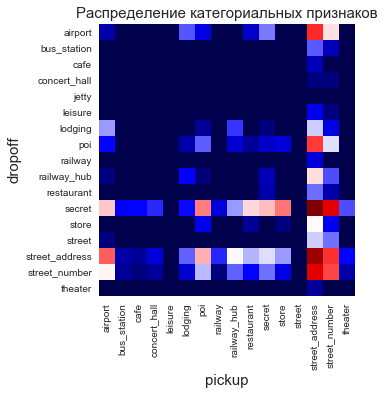

In [31]:
cat_imshow('pickup','dropoff',data)

dayOfWeek_cat          pickup  count
0        friday  street_address  11043
1      thursday  street_address   8729
2       tuesday  street_address   8639
3     wednesday  street_address   8566
4        monday  street_address   7855

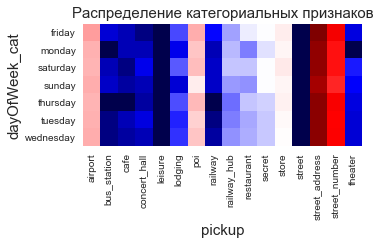

In [32]:
cat_imshow('pickup','dayOfWeek_cat',data)

status vendor_id  count
0       done         B  40202
1       done         A  22124
2  cancelled         B   5304
3  cancelled         A   2391
4       done         C    127

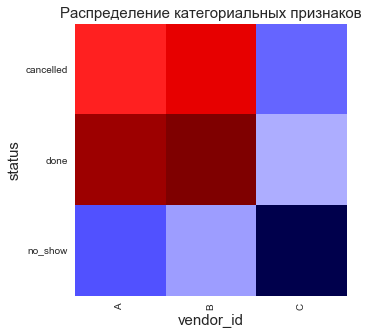

In [33]:
cat_imshow('vendor_id','status',data)

payment_type vendor_id  count
0         card         B  29347
1         card         A  21700
2      invoice         B  15208
3      invoice         A   1996
4    apple_pay         B   1060

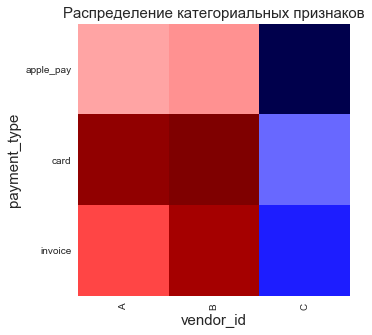

In [34]:
cat_imshow('vendor_id','payment_type',data)

vendor_id          pickup  count
0         B  street_address  36975
1         A  street_address  20957
2         B   street_number   5404
3         A   street_number   1764
4         B             poi    906

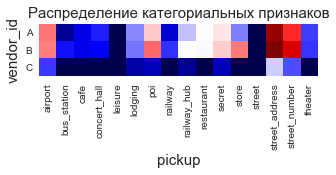

In [35]:
cat_imshow('pickup','vendor_id',data)

**Данные о пользователях**

app__os       utm_medium  count
0      iOS           invite   1956
1      iOS          organic   1287
2  android           invite   1082
3  android          organic    312
4      iOS  cross-promotion    127

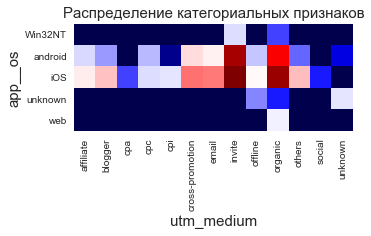

In [36]:
cat_imshow('utm_medium','app__os',users)

Далее расмотрим  соотношение категориальных внутри других категориальных
Будем искать признаки с распределением внутри категориальной сильно отличающееся от распеределения в среднем по категориальной переменной.

В данном случае актуален процент отмененных заказов относительно выполненых в зависимости от места посадки клиента, признак dropoff - место высадки клиента, содержит более половины пропусков поэтому менее информативен. Всю аналитику по категориальных признаком лучше смотреть по признаку  pickup - место посадки клиента

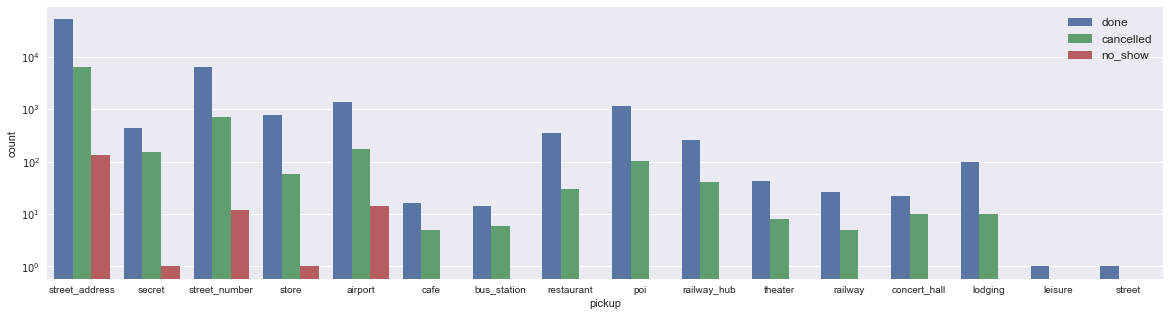

In [49]:
def countplot_def(x,hue,data):
    plt.figure(figsize=(20,5))
    sns.countplot(x=x, hue=hue, data=data);
    sns.set(font_scale=1.2)
    plt.legend(loc='upper right');
    plt.yscale('log')

countplot_def('pickup','status',data)

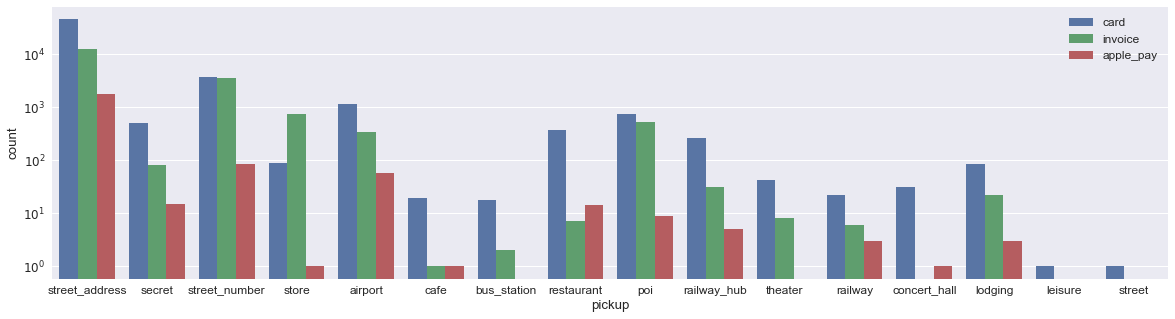

In [50]:
countplot_def('pickup','payment_type',data)

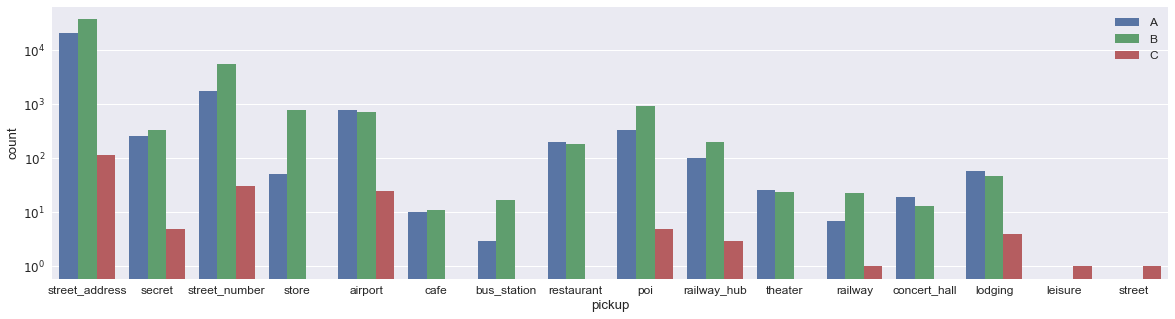

In [51]:
countplot_def('pickup','vendor_id',data)

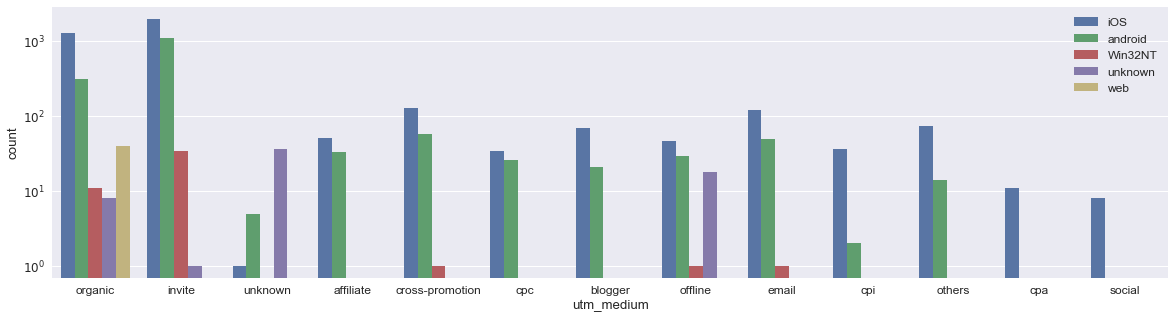

In [52]:
countplot_def('utm_medium','app__os',users)

In [37]:
with open('data.pkl', 'wb') as fp:
    pickle.dump(data, fp)

###  Часть 6. Поиск кластера нестандартных объектов набора данных

In [38]:
import pickle
with open('data.pkl', 'rb') as f:
    data = pickle.load(f)

Пронализируем выборку на наличие нестандатрных объектов / транзакций. Анализировать будем датасет предполагая, что все транзакции независимы, т.е. каждую транзакцию совершает разный клиент. Поэтому данные о транзакциях не будут мерджиться с данными о пользователях.

In [39]:
drop_features=['_id','user_id','completed_at','day','dayOfWeek_cat']
data_get_dummies=data.drop(drop_features, axis=1 )

cat_features_svm=data_get_dummies.select_dtypes(include=['object']).columns.values.tolist()
data_get_dummies=pd.get_dummies(data=data_get_dummies,columns=cat_features_svm)
data_get_dummies.shape

(70375, 49)

In [40]:
from sklearn import svm
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

scaler = StandardScaler()
data_scaler = scaler.fit_transform(data_get_dummies)

In [57]:
%%time
data_PCA = PCA(n_components=2).fit_transform(data_scaler)
svm_clf = svm.OneClassSVM(kernel="rbf",verbose=1,random_state=7)
svm_clf.fit(data_PCA)

with open('svm_clf.pkl', 'wb') as fp:
    pickle.dump(svm_clf, fp)

[LibSVM]Wall time: 3min 33s


In [58]:
%%time
OUTLIER_FRACTION = 0.01

dist_to_border = svm_clf.decision_function(data_PCA).ravel() # ravel() делает массив плоским
threshold = stats.scoreatpercentile(dist_to_border,
            100 * OUTLIER_FRACTION)
is_outlier_1pct = dist_to_border < threshold

with open('is_outlier_'+ str(OUTLIER_FRACTION)+'.pkl', 'wb') as fp:
    pickle.dump(is_outlier_1pct, fp)

Wall time: 56.8 s


Wall time: 3min 16s


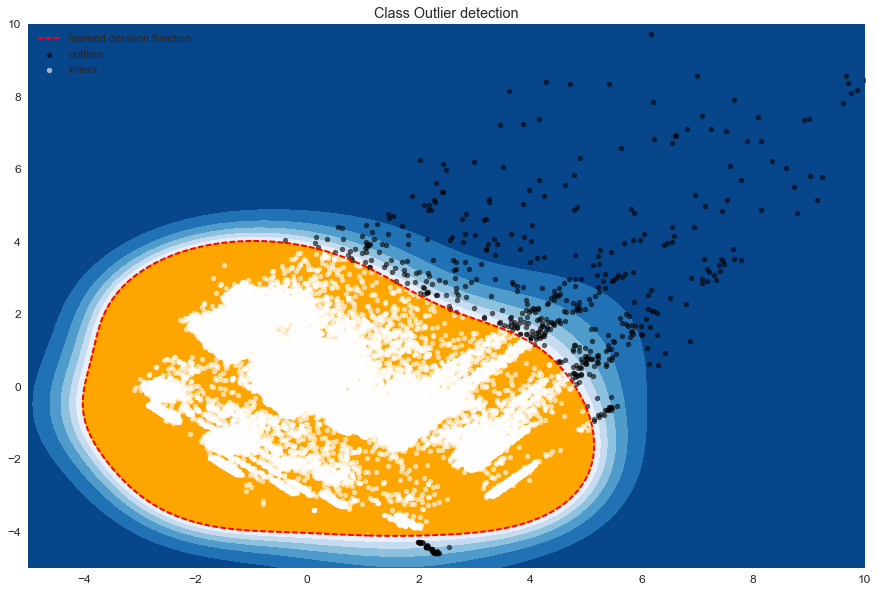

In [59]:
%%time
is_outlier=is_outlier_1pct
data_outliers_num = data_scaler.shape[0]
xx, yy = np.meshgrid(np.linspace(-10, 10, 500), np.linspace(-10, 10, 500))
n_inliers = int((1. - OUTLIER_FRACTION) * data_outliers_num)
n_outliers = int(OUTLIER_FRACTION * data_outliers_num)
Z = svm_clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(15,10))
plt.title("Class Outlier detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                         cmap=plt.cm.Blues_r)
a = plt.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, colors='red')
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                         colors='orange')
b = plt.scatter(data_PCA[is_outlier, 0], data_PCA[is_outlier, 1], c='black', s=25, alpha=0.6)
c = plt.scatter(data_PCA[is_outlier == 0, 0], data_PCA[is_outlier == 0, 1], c='white',s=25, alpha=0.6)
plt.axis('tight')
plt.legend([a.collections[0], b, c],
           ['learned decision function', 'outliers', 'inliers'],
           prop=matplotlib.font_manager.FontProperties(size=11),loc='upper left')

plt.xlim((-5, 10))
plt.ylim((-5, 10));

In [61]:
%%time
OUTLIER_FRACTION = 0.05

dist_to_border = svm_clf.decision_function(data_PCA).ravel() # ravel() делает массив плоским
threshold = stats.scoreatpercentile(dist_to_border,
            100 * OUTLIER_FRACTION)
is_outlier_5pct = dist_to_border < threshold

with open('is_outlier_'+ str(OUTLIER_FRACTION)+'.pkl', 'wb') as fp:
    pickle.dump(is_outlier_5pct, fp)

Wall time: 55 s


Wall time: 3min 16s


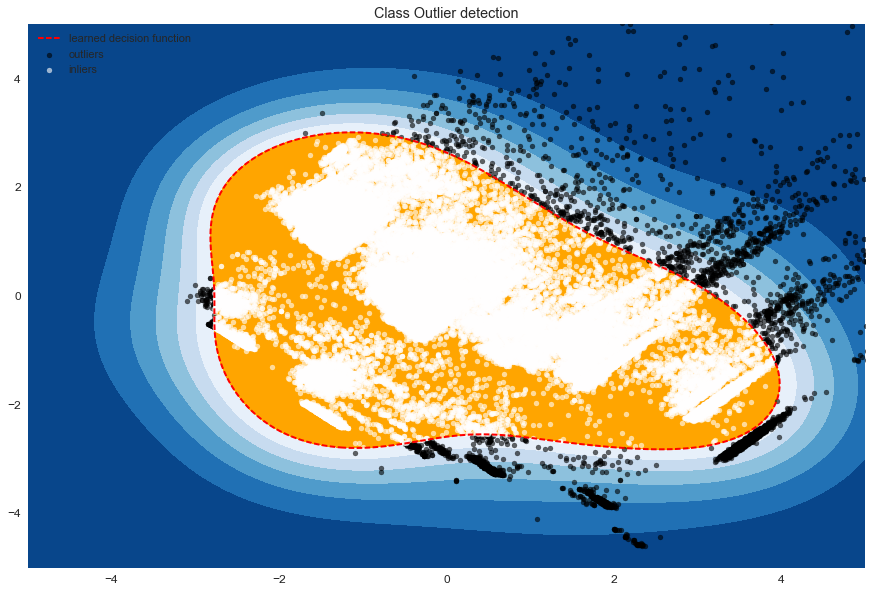

In [62]:
%%time
is_outlier=is_outlier_5pct
data_outliers_num = data_scaler.shape[0]
xx, yy = np.meshgrid(np.linspace(-10, 10, 500), np.linspace(-10, 10, 500))
n_inliers = int((1. - OUTLIER_FRACTION) * data_outliers_num)
n_outliers = int(OUTLIER_FRACTION * data_outliers_num)
Z = svm_clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(15,10))
plt.title("Class Outlier detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                         cmap=plt.cm.Blues_r)
a = plt.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, colors='red')
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                         colors='orange')
b = plt.scatter(data_PCA[is_outlier, 0], data_PCA[is_outlier, 1], c='black', s=25, alpha=0.6)
c = plt.scatter(data_PCA[is_outlier == 0, 0], data_PCA[is_outlier == 0, 1], c='white',s=25, alpha=0.6)
plt.axis('tight')
plt.legend([a.collections[0], b, c],
           ['learned decision function', 'outliers', 'inliers'],
           prop=matplotlib.font_manager.FontProperties(size=11),loc='upper left')

plt.xlim((-5, 5))
plt.ylim((-5, 5));

Заметно, что с ростом OUTLIER_FRACTION начинает отъдаться часть кластерной структуры даннных. Выберем в качестве значения OUTLIER_FRACTION равное 1% для выделения нестандартных объектов.

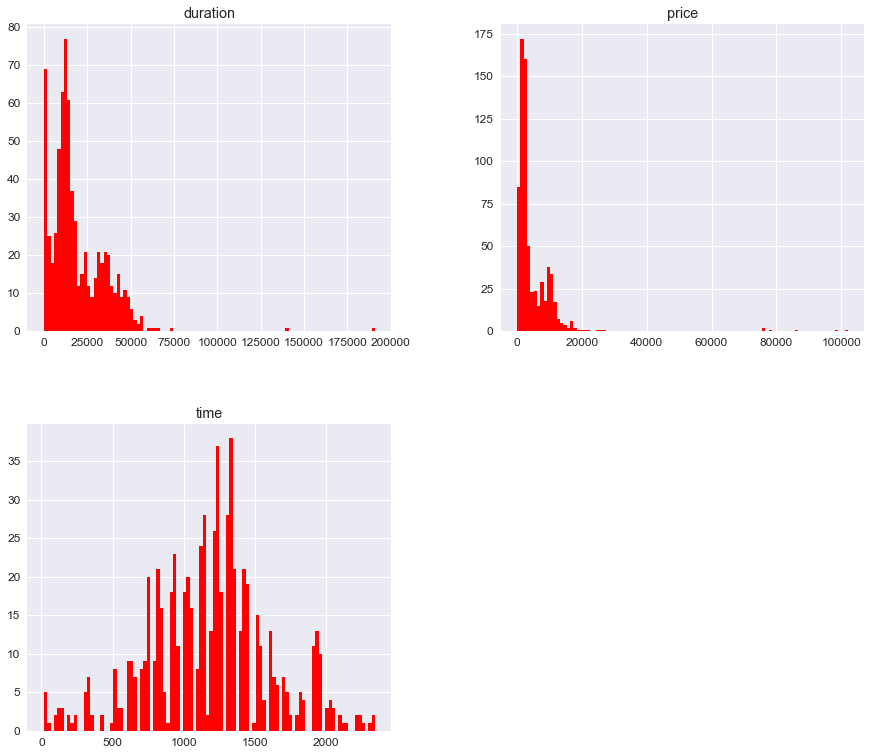

In [63]:
data[is_outlier_1pct][['duration','price','time']].hist(figsize=(15, 13),bins=100,color='r');

In [64]:
data[real_features].median()

duration      978.0
distance     5033.0
price         252.0
credit          0.0
to_pay          0.0
time         1316.0
dayOfWeek       3.0
dtype: float64

In [65]:
data[is_outlier_1pct][real_features].median()

duration     14348.5
distance     74859.0
price         2483.5
credit           0.0
to_pay           0.0
time          1214.5
dayOfWeek        2.0
dtype: float64

status          pickup  count
0       done  street_address    390
1       done   street_number    194
2  cancelled           store     42
3       done         airport     25
4       done             poi     15

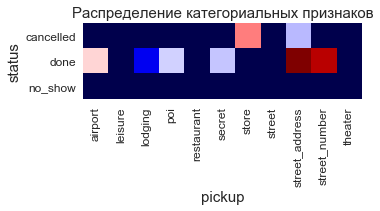

In [66]:
cat_imshow('pickup','status',data[is_outlier_1pct])

###  Часть 7. Применение различных подходов кластеризации  набора данных

**Staked kMeans**

Для кластеризации необходимо нормализовать значения факторов. Для того чтобы отобразить набор данных на двумерную плоскость понизим размерность. Визуально оценим наличие кластерной структуры в сырых данных.

In [41]:
%%time
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

with open('is_outlier_0.01.pkl', 'rb') as f:
    is_outlier_1pct = pickle.load(f)

scaler = StandardScaler()
data_scaler = scaler.fit_transform(data_get_dummies[~is_outlier_1pct])
pca = PCA(n_components=2).fit_transform(data_scaler) 
print (pca.shape)

(69671, 2)
Wall time: 766 ms


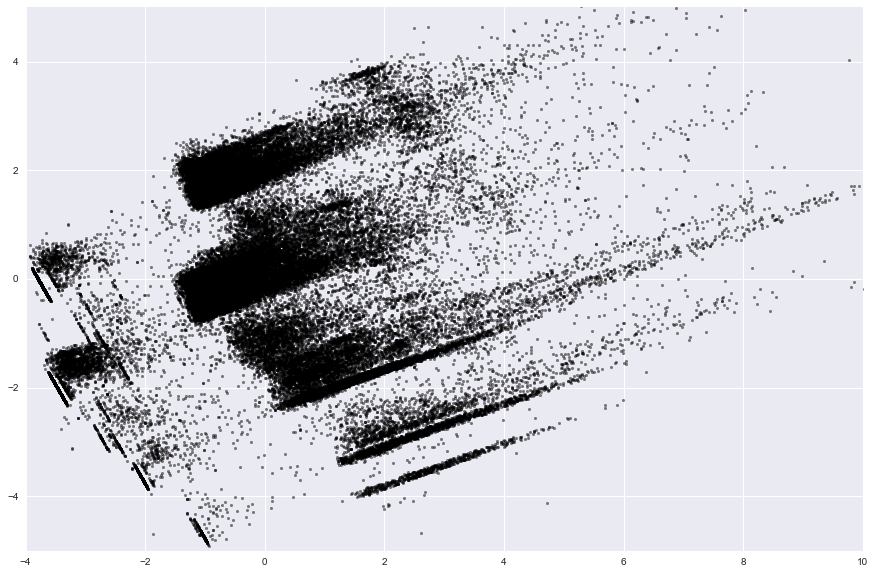

In [42]:
plt.figure(figsize=(15,10))
plt.scatter(pca[:, 0], pca[:, 1], s=7, c ='k',alpha=0.5);
plt.xlim((-4, 10))
plt.ylim((-5, 5));

Проверка наличия кластерной структуры в данных - статистика Хопкинса - Hopkins test for cluster tendency

In [63]:
# https://matevzkunaver.wordpress.com/2017/06/20/hopkins-test-for-cluster-tendency/
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) # heuristic from article [1]
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in  tqdm(range(0, m)):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print (ujd, wjd)
        H = 0
 
    return H

In [44]:
%%time
hopkins(pd.DataFrame(data_scaler)) # принимает объект DataFrame

100%|██████████████████████████████████████| 6967/6967 [10:24<00:00, 11.30it/s]


Wall time: 10min 56s


0.99877941862341346

Значение статистики Хопкинса говорит о сильной кластерной структуре в датасете

Выберем число кластеров для kMeans через метрику - суммы квадратов расстояний от точек до центроидов кластеров, к которым они относятся - kmeans.inertia_

In [66]:
def inertia_claster(range_n_clusters, data_scaler):
    inertia = []
    for n_clusters in tqdm(range_n_clusters):
        kmeans = KMeans(n_clusters=n_clusters, max_iter=500, random_state=7).fit(data_scaler)
        inertia.append(np.sqrt(kmeans.inertia_))

    plt.plot(range_n_clusters, inertia, marker='s');
    plt.xlabel('$k$')
    plt.ylabel('$J(C_k)$');

100%|██████████████████████████████████████████| 20/20 [12:28<00:00, 73.35s/it]


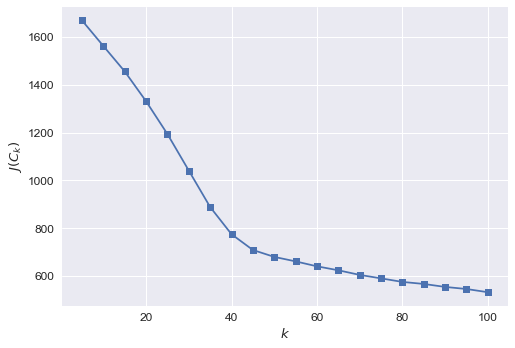

In [71]:
from sklearn.cluster import KMeans

range_n_clusters = range(5,101,5)
inertia_claster(range_n_clusters, data_scaler)

Оценим оптимальное число кластеров через коэффициент силуэта

Силуэтом выборки называется средняя величина силуэта объектов данной выборки. Таким образом, силуэт показывает, насколько среднее расстояние до объектов своего кластера отличается от среднего расстояния до объектов других кластеров. Данная величина лежит в диапазоне [-1,+1]. Значения, близкие к -1, соответствуют плохим (разрозненным) кластеризациям, значения, близкие к нулю, говорят о том, что кластеры пересекаются и накладываются друг на друга, значения, близкие к 1, соответствуют "плотным" четко выделенным кластерам. Таким образом, чем больше силуэт, тем более четко выделены кластеры, и они представляют собой компактные, плотно сгруппированные облака точек.

In [67]:
def silhouette_cluster (sample_size,range_n_clusters, data_scaler):
    silhouette_avg_list = []
    under_silhouette_avg_list = []

    for n_clusters in tqdm(range_n_clusters):
        kmeans = KMeans(n_clusters=n_clusters, max_iter=500, random_state=7).fit(data_scaler)
        cluster_labels = kmeans.labels_
        silhouette_avg = silhouette_score(data_scaler, cluster_labels, sample_size=sample_size ) # sample_size=5000
        silhouette_avg_list.append(silhouette_avg)
        sample_silhouette_values = silhouette_samples(data_scaler[:sample_size], cluster_labels[:sample_size])
        under_silhouette_avg_list.append( (sample_silhouette_values>silhouette_avg).sum()/sample_size )

    return silhouette_avg_list,under_silhouette_avg_list

In [46]:
from sklearn.metrics import silhouette_samples, silhouette_score
sample_size=5000
range_n_clusters = range(5,101,5)
silhouette_avg_list,under_silhouette_avg_list = silhouette_cluster(sample_size,range_n_clusters, data_scaler )

100%|██████████████████████████████████████████| 20/20 [12:40<00:00, 78.96s/it]


In [68]:
def silhouette_plot(range_n_clusters, silhouette_avg_list, under_silhouette_avg_list):
    plt.figure(figsize=(15,10))
    ax = plt.subplot(221)
    ax.plot(silhouette_avg_list);
    plt.xticks(range(len(range_n_clusters)), range_n_clusters);
    plt.title("The average silhouette_score");

    ax = plt.subplot(222) 
    ax.plot(under_silhouette_avg_list);
    plt.xticks(range(len(range_n_clusters)), range_n_clusters);
    plt.title("% under average silhouette_score");

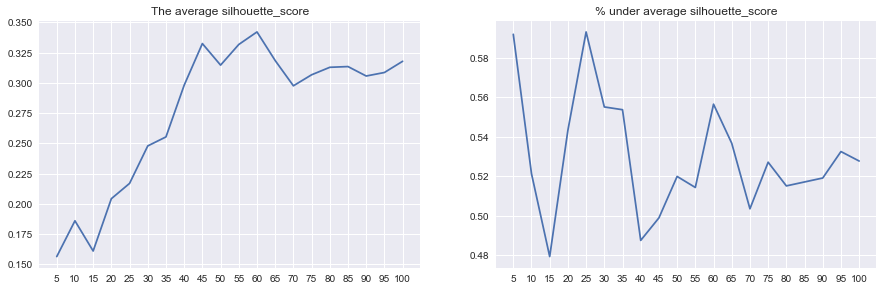

In [48]:
silhouette_plot(range_n_clusters, silhouette_avg_list, under_silhouette_avg_list)

Согласно двум разным расчетам имеем одинаковое оптимальное количество кластеров не смотря на то что силуэт выборки считалсчя на сэмпле данных.  Выбирем количество кластеров равным 40

For n_clusters = 40 The average silhouette_score is : 0.322489470551


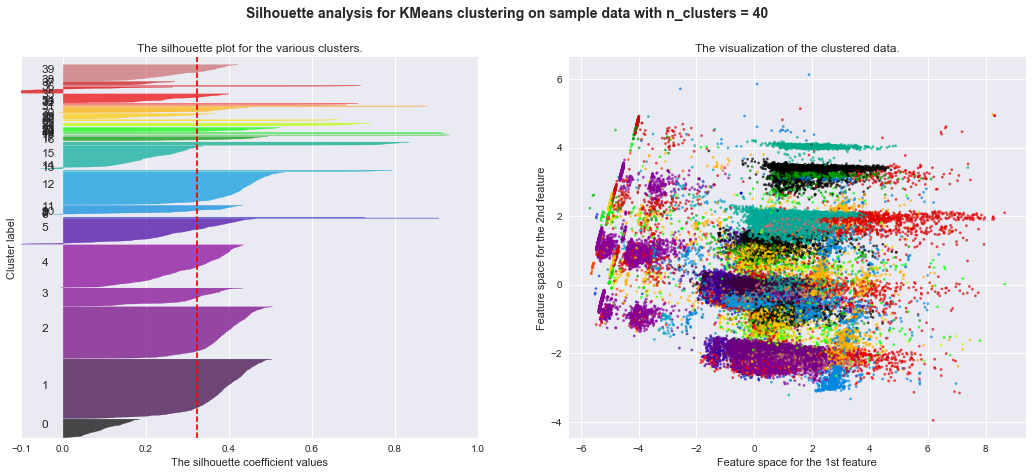

In [80]:
range_n_clusters = [40]
# для отображения на плоскость будем использовать pca
X =data_scaler  #
sample_size=5000

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmeans = KMeans(n_clusters=n_clusters, max_iter=500, random_state=7)
    cluster_labels = kmeans.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels, sample_size=sample_size ) # sample_size=5000
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X[:sample_size], cluster_labels[:sample_size])# корректировка

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels[:sample_size] == i] # корректировка

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    ax1.set_ylim(0,sample_size*1.1) # корректировка

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    # чтобы нарисовать нужно 2 мерное пространство признаков
    ax2.scatter(pca[:, 0], pca[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors)
    # Labeling the clusters
    centers = kmeans.cluster_centers_
    # центры кластеров имеют размерность ту для какого датасета выполнялся kmeans
    # если kmeans делался не для pca то  рисовать центры кластеров нет смысла

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

Распределение количества объектов в кластерах

In [50]:
pd.Series(kmeans.labels_).value_counts()[:10]

0     11131
14     7745
4      7240
9      6423
37     5644
1      5090
11     4843
32     4747
33     4080
7      1810
dtype: int64

Количество кластеров полученных kMeans с числом объектов больше 1000

In [51]:
sum(pd.Series(kmeans.labels_).value_counts()>1000)

15

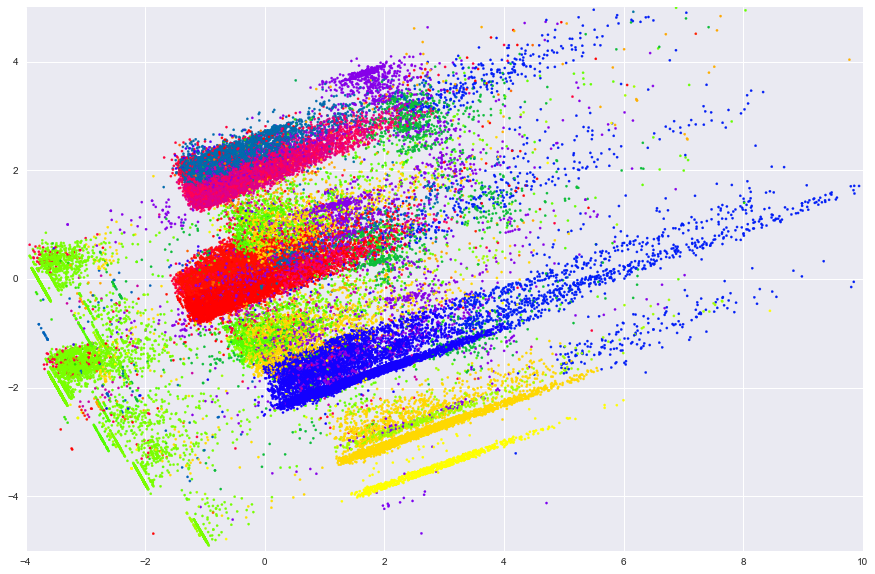

In [52]:
plt.figure(figsize=(15,10))
plt.scatter(pca[:, 0], pca[:, 1], c=kmeans.labels_,  s=5, cmap='prism');
# Plot the centroids as a white X
# centroids = kmeans.cluster_centers_
# рисовать центроиды имеет смыл если сначала выполняется pca а затем kmeans
plt.xlim((-4, 10))
plt.ylim((-5, 5));

Визуализируем самый крупный кластер

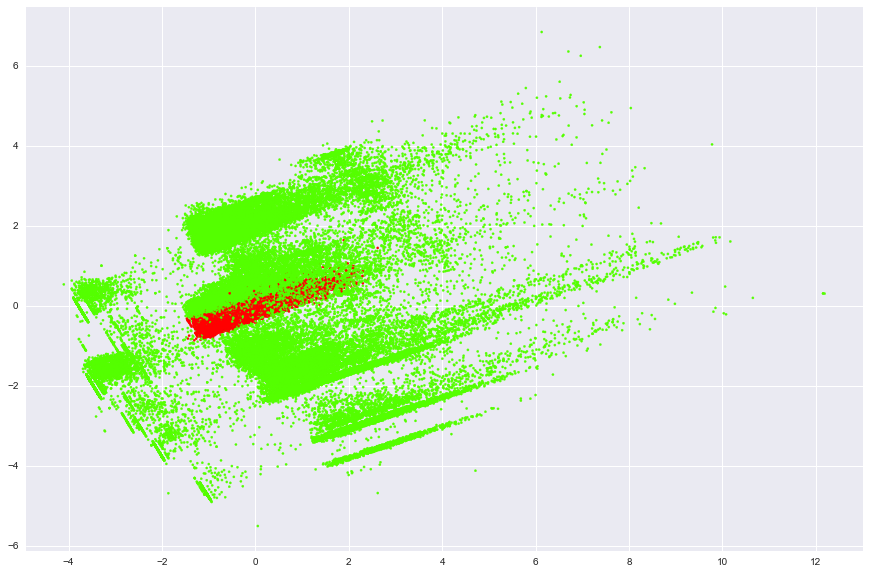

In [53]:
plt.figure(figsize=(15,10))
plt.scatter(pca[:, 0], pca[:, 1], c=kmeans.labels_!=0,  s=5, cmap='prism');

Текущая структура  расположения объектов датасета на плоскости визуально показывает на наличие ленточных кластеров. С такими типами кластеров хорошо справляются алгоритмы кластеризации основаные на плотности точек кластера. Попробуем алгоритм DBSCAN

In [84]:
%%time
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.25, min_samples=5, metric='euclidean').fit(data_scaler)

Wall time: 12min 3s


In [85]:
(pd.Series(db.labels_).value_counts()[:15])

-1     27740
 73     1822
 75     1821
 40     1369
 24     1364
 52     1318
 11     1200
 81     1178
 83     1163
 26     1066
 55     1065
 39     1040
 72      995
 53      877
 28      840
dtype: int64

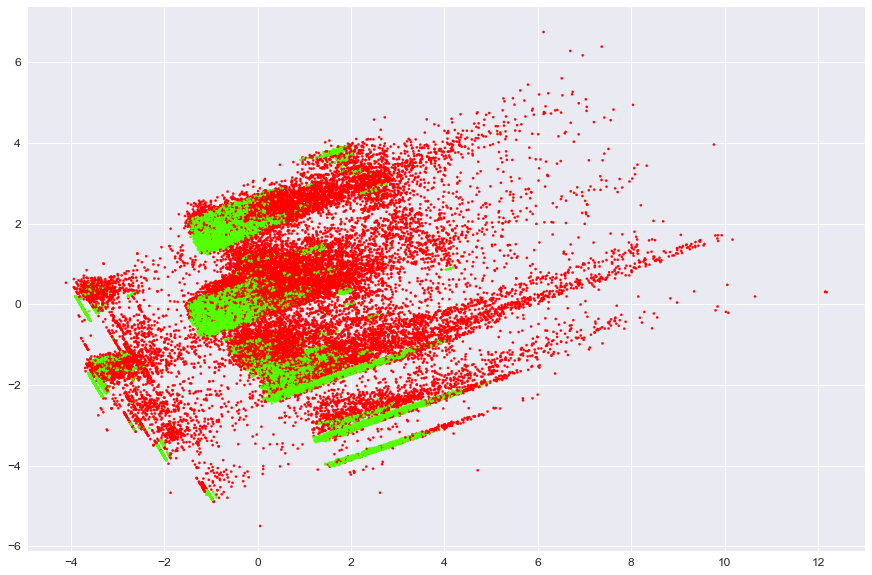

In [86]:
# красным показаны шумовые точки
plt.figure(figsize=(15,10))
plt.scatter(pca[:, 0], pca[:, 1], c=db.labels_!=-1,  s=5, cmap='prism');

Шумовые точки занимают более 30% датасета. В качестве базового алгоритма кластеризации оставим kMeans

Мы кластеризовали  транзакции клиентов. Для кластеризации самих клиентов сделаем новыми признаками клиента  номера кластеров куда попали его транзации. Добавим эти признаки к app_os - Операционная система гаджета пользователя, utm_medium
источник, по которому пришел пользователь. Применим к такому датасету снова алгоритм кластеризации - kMeans

In [54]:
kmeans_data = pd.DataFrame(data['user_id'], index=data.index)
kmeans_labels = pd.DataFrame(data=kmeans.labels_, index=data[~is_outlier_1pct].index)
kmeans_data['label'] = kmeans_labels
kmeans_data.fillna(-1,inplace=True) # nan = is_outlier_1pct
del kmeans_labels

In [55]:
kmeans_data = pd.get_dummies(data=kmeans_data, columns=['label']) 
kmeans_data = kmeans_data.groupby(kmeans_data['user_id']).sum()
kmeans_data = kmeans_data.merge(users, left_index=True, right_on='_id')
kmeans_data.index=kmeans_data['_id']
kmeans_data.drop(['_id'], axis=1, inplace=True )
kmeans_data = pd.get_dummies(data=kmeans_data, columns=['utm_medium','app__os']) 
kmeans_data.shape

(5599, 59)

In [56]:
scaler = StandardScaler()
kmeans_data_scaler = scaler.fit_transform(kmeans_data)
pca = PCA(n_components=2).fit_transform(kmeans_data_scaler) 
print (pca.shape)

(5599, 2)


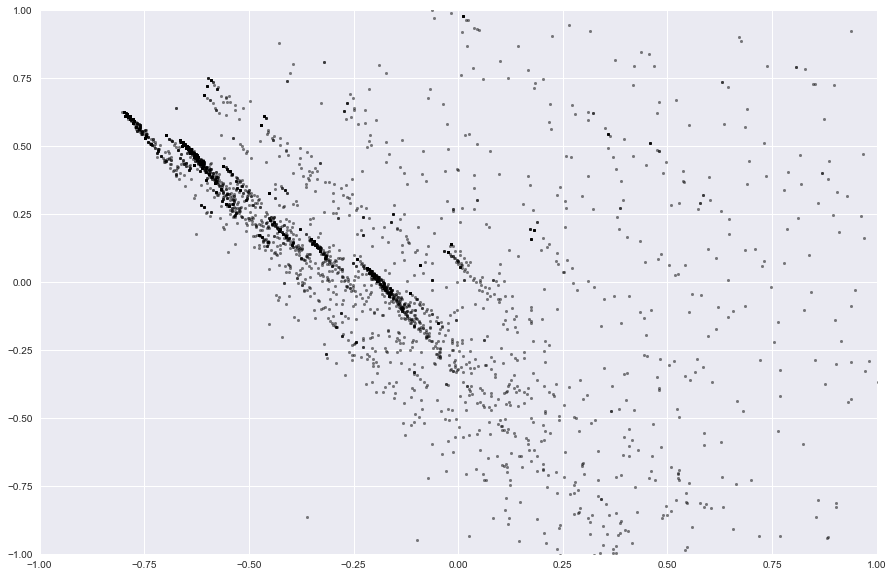

In [57]:
plt.figure(figsize=(15,10))
plt.scatter(pca[:, 0], pca[:, 1], s=7, c ='k',alpha=0.5);
plt.xlim((-1, 1))
plt.ylim((-1, 1));

In [91]:
%%time
hopkins(pd.DataFrame(kmeans_data_scaler)) # принимает объект DataFrame

100%|████████████████████████████████████████| 559/559 [00:06<00:00, 88.60it/s]


Wall time: 6.41 s


0.9940132111006138

Значение статистики Хопкинса говорит о наличии кластерной структуры, пордберем число кластеров

100%|██████████████████████████████████████████| 49/49 [02:46<00:00,  6.00s/it]


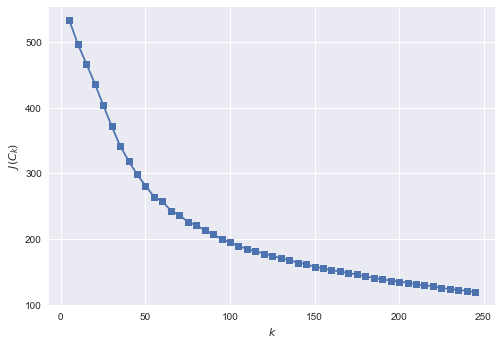

In [58]:
range_n_clusters = range(5,250,5)
inertia_claster(range_n_clusters, kmeans_data_scaler )

In [59]:
from sklearn.metrics import silhouette_samples, silhouette_score
range_n_clusters = range(5,150,5)
sample_size=5000
silhouette_avg_list,under_silhouette_avg_list = silhouette_cluster (sample_size,range_n_clusters, kmeans_data_scaler )

100%|██████████████████████████████████████████| 29/29 [02:09<00:00,  6.44s/it]


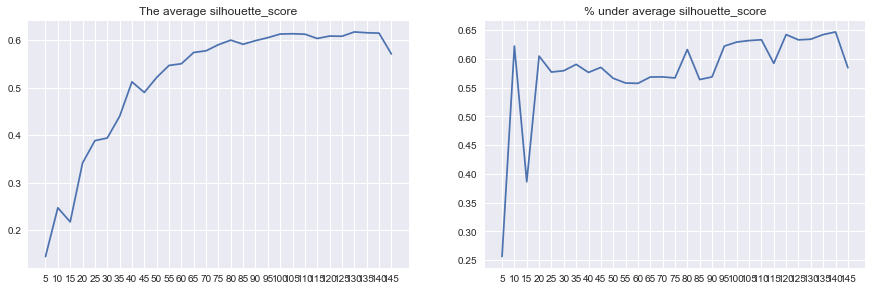

In [60]:
range_n_clusters = range(5,150,5)
silhouette_plot(range_n_clusters, silhouette_avg_list, under_silhouette_avg_list)

In [61]:
under_silhouette_avg_list.index(max(under_silhouette_avg_list))*5+5

140

Выберем оптимальное число кластеров  80, сегментация в % от общего числа клиентов будет выглядеть 

In [62]:
kmeans = KMeans(n_clusters=80, max_iter=500, random_state=7).fit(kmeans_data_scaler)
cluster_pct = pd.Series(kmeans.labels_).value_counts()[:10]*100./(len(kmeans.labels_))
cluster_pct

13    32.005715
2     18.521164
7     16.895874
42     4.625826
11     3.071977
28     2.768351
8      1.589570
20     1.428827
21     1.339525
60     1.285944
dtype: float64

При минамальном пороге сегментирования для таргетинговой рекламы клиентов в 5% будет охват клиентов в %

In [63]:
cluster_pct[cluster_pct>5].sum()

67.42275406322557

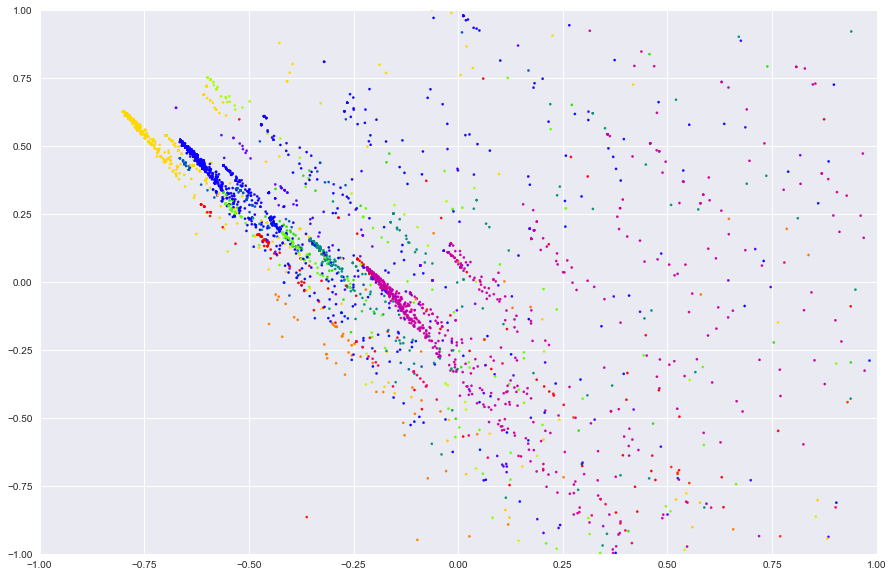

In [64]:
plt.figure(figsize=(15,10))
plt.scatter(pca[:, 0], pca[:, 1], c=kmeans.labels_,  s=5, cmap='prism');
plt.xlim((-1, 1))
plt.ylim((-1, 1));

Подберем оптимальное число кластеров для равномерного распределения между кластерами

In [65]:
cluster_sum,cluster_largest =[], []
range_n_clusters = range(5,150,5)
for n_clusters in tqdm(range_n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, max_iter=500, random_state=7).fit(kmeans_data_scaler) # kmeans_data_scaler!!
    cluster_pct = pd.Series(kmeans.labels_).value_counts()[:10]*100./(len(kmeans.labels_))
    cluster_sum.append( cluster_pct[cluster_pct>5].sum() )
    cluster_largest.append( cluster_pct.max() )

100%|██████████████████████████████████████████| 29/29 [00:58<00:00,  3.29s/it]


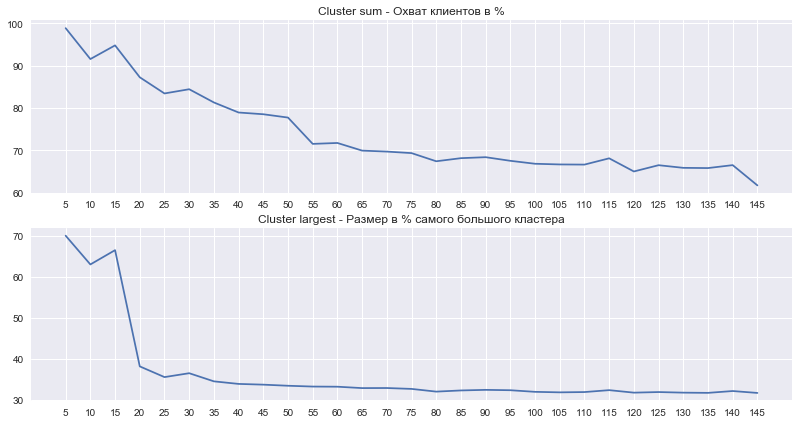

In [66]:
plt.figure(figsize=(30,7))
ax = plt.subplot(221)
ax.plot(cluster_sum);
plt.xticks(range(len(range_n_clusters)), range_n_clusters);
plt.title("Cluster sum - Охват клиентов в %");

ax = plt.subplot(223) 
ax.plot(cluster_largest);
plt.xticks(range(len(range_n_clusters)), range_n_clusters);
plt.title("Cluster largest - Размер в % самого большого кластера");

In [67]:
kmeans = KMeans(n_clusters=35, max_iter=500, random_state=7).fit(kmeans_data_scaler)
cluster_pct = pd.Series(kmeans.labels_).value_counts()[:10]*100./(len(kmeans.labels_))
cluster_pct

1     34.506162
5     24.165029
2     22.646901
19     3.232720
8      2.964815
23     1.589570
32     1.589570
13     1.500268
18     1.464547
34     1.053760
dtype: float64

In [68]:
with open('kmeans_staked.pkl', 'wb') as fp:
    pickle.dump(kmeans, fp)

С увеличением количества признаков методы кластеризации сталкиваются с таким явлением как проклятие размерности - когда расстояние межды объектами выборки стоновится одинаковым. Тем не менее добавим два новых признака - долю оплаты бонусами общей стоимости поездки, отношение дистанции заказа к продолжительность заказа -  аналог наличия пробок по пути маршрута.

In [69]:
data_get_dummies['trafic']=data_get_dummies['distance'] /(0.001+data_get_dummies['duration'])
data_get_dummies['ratio_bonus']=data_get_dummies['price'] /(0.001+data_get_dummies['credit'])

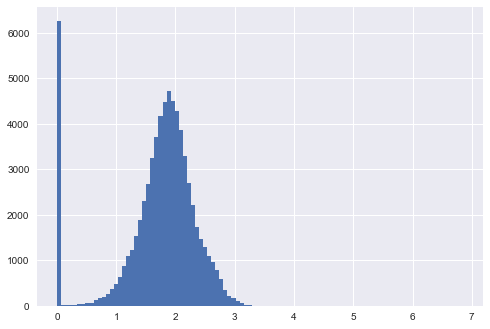

In [70]:
data_get_dummies['trafic'].apply(lambda x: np.log1p(x)).hist(bins=100);

In [71]:
data_get_dummies['trafic'] = data_get_dummies['trafic'].apply(lambda x: np.log1p(x))
data_get_dummies['ratio_bonus'] = data_get_dummies['ratio_bonus'].apply(lambda x: np.log1p(x))

In [72]:
scaler = StandardScaler()
data_scaler = scaler.fit_transform(data_get_dummies[~is_outlier_1pct])
pca = PCA(n_components=2).fit_transform(data_scaler) 

(-6, 6)

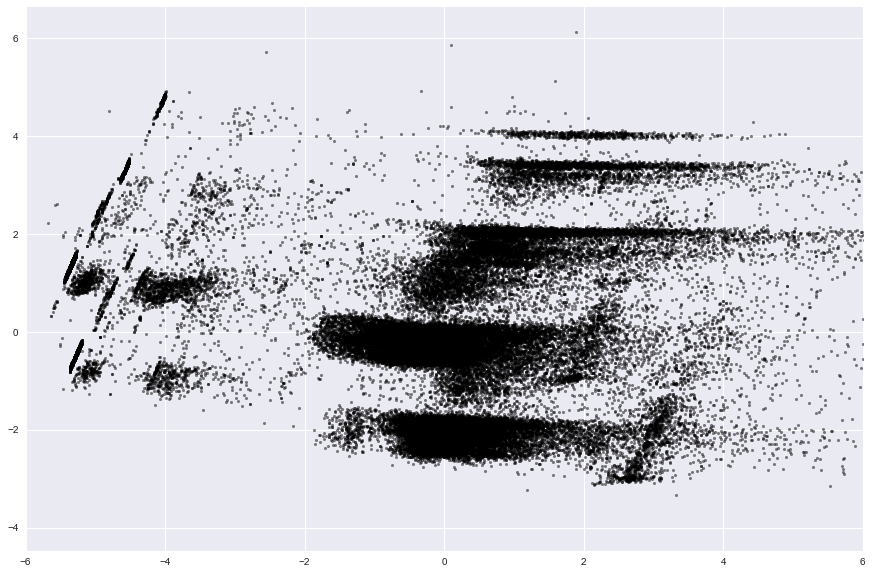

In [73]:
plt.figure(figsize=(15,10))
plt.scatter(pca[:, 0], pca[:, 1], s=7, c ='k',alpha=0.5);
plt.xlim((-6, 6))

100%|██████████████████████████████████████████| 20/20 [11:10<00:00, 59.74s/it]


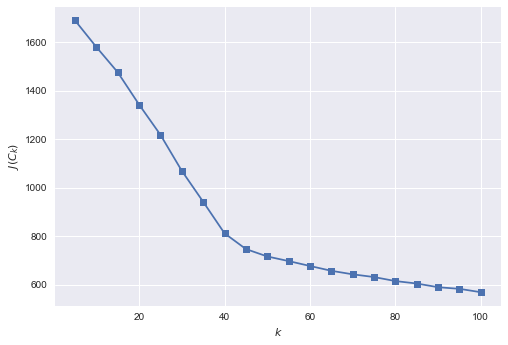

In [74]:
range_n_clusters = range(5,101,5)
inertia_claster(range_n_clusters, data_scaler)

In [75]:
sample_size=5000
range_n_clusters = range(5,101,5)
silhouette_avg_list,under_silhouette_avg_list = silhouette_cluster(sample_size,range_n_clusters, data_scaler )

100%|██████████████████████████████████████████| 20/20 [12:27<00:00, 67.26s/it]


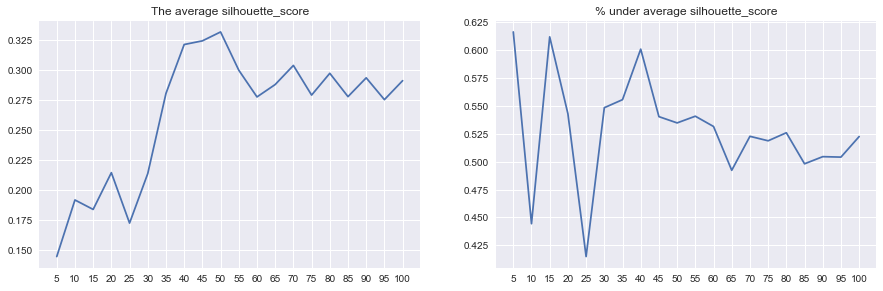

In [76]:
silhouette_plot(range_n_clusters, silhouette_avg_list, under_silhouette_avg_list)

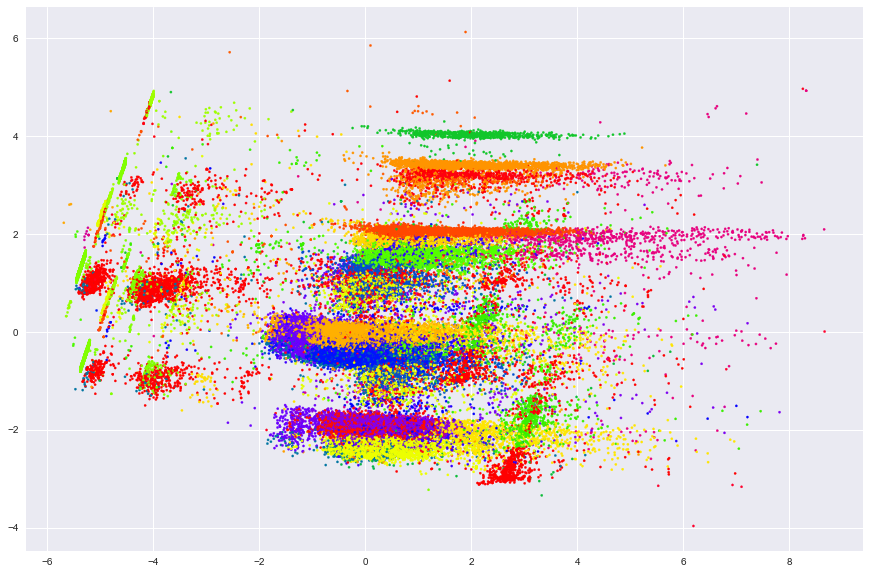

In [81]:
n_clusters=50
kmeans = KMeans(n_clusters=n_clusters, max_iter=500, random_state=7).fit(data_scaler)

plt.figure(figsize=(15,10))
plt.scatter(pca[:, 0], pca[:, 1], c=kmeans.labels_,  s=5, cmap='prism');

In [82]:
pd.Series(kmeans.labels_).value_counts()[:10]

1     10266
8      6012
32     4881
38     4241
5      4139
39     4098
2      3671
41     3185
49     2876
4      2671
dtype: int64

In [83]:
cluster_pct = pd.Series(kmeans.labels_).value_counts()[:10]*100./(len(kmeans.labels_))
cluster_pct

1     14.734969
8      8.629128
32     7.005784
38     6.087181
5      5.940779
39     5.881931
2      5.269050
41     4.571486
49     4.127973
4      3.833733
dtype: float64

Мы получили в итоге более равномерное распределение кластеров транзакций пользователей

In [84]:
kmeans_data = pd.DataFrame(data['user_id'], index=data.index)
kmeans_labels = pd.DataFrame(data=kmeans.labels_, index=data[~is_outlier_1pct].index)
kmeans_data['label'] = kmeans_labels
kmeans_data.fillna(-1,inplace=True) # nan = is_outlier_1pct
del kmeans_labels
kmeans_data = pd.get_dummies(data=kmeans_data, columns=['label']) 
kmeans_data = kmeans_data.groupby(kmeans_data['user_id']).sum()
kmeans_data = kmeans_data.merge(users, left_index=True, right_on='_id')
kmeans_data.index=kmeans_data['_id']
kmeans_data.drop(['_id'], axis=1, inplace=True )
kmeans_data = pd.get_dummies(data=kmeans_data, columns=['utm_medium','app__os']) 
kmeans_data.shape

(5599, 69)

In [85]:
scaler = StandardScaler()
kmeans_data_scaler = scaler.fit_transform(kmeans_data)
pca = PCA(n_components=2).fit_transform(kmeans_data_scaler) 
print (pca.shape)

(5599, 2)


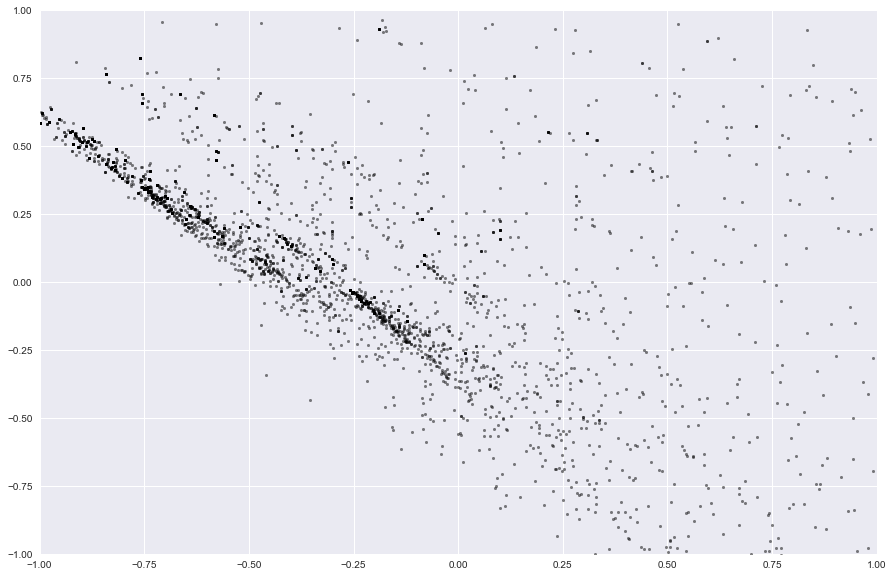

In [86]:
plt.figure(figsize=(15,10))
plt.scatter(pca[:, 0], pca[:, 1], s=7, c ='k',alpha=0.5);
plt.xlim((-1, 1))
plt.ylim((-1, 1));

100%|██████████████████████████████████████████| 49/49 [03:02<00:00,  6.66s/it]


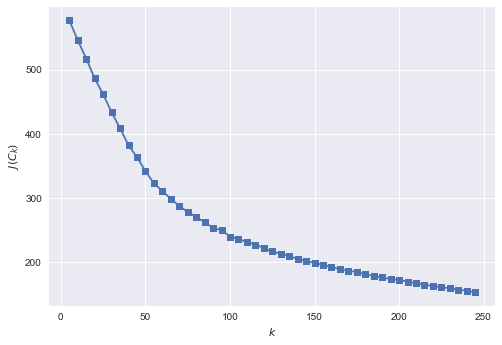

In [87]:
range_n_clusters = range(5,250,5)
inertia_claster(range_n_clusters, kmeans_data_scaler )

In [88]:
from sklearn.metrics import silhouette_samples, silhouette_score
range_n_clusters = range(5,150,5)
sample_size=5000
silhouette_avg_list,under_silhouette_avg_list = silhouette_cluster (sample_size,range_n_clusters, kmeans_data_scaler )

100%|██████████████████████████████████████████| 29/29 [02:23<00:00,  7.37s/it]


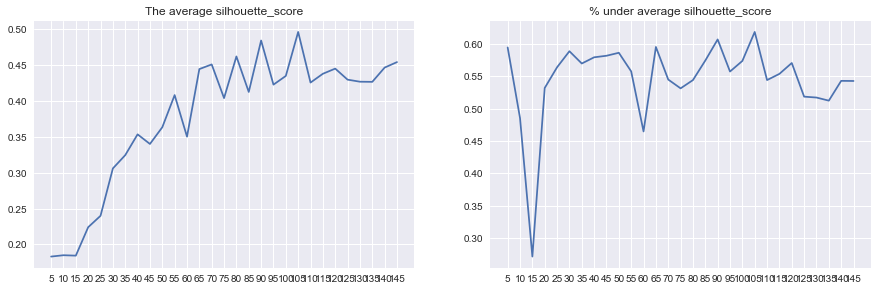

In [89]:
silhouette_plot(range_n_clusters, silhouette_avg_list, under_silhouette_avg_list)

In [90]:
under_silhouette_avg_list.index(max(under_silhouette_avg_list))*5+5

105

In [93]:
kmeans = KMeans(n_clusters=105, max_iter=500, random_state=7).fit(kmeans_data_scaler)
cluster_pct = pd.Series(kmeans.labels_).value_counts()[:10]*100./(len(kmeans.labels_))
cluster_pct

0     30.809073
7     17.538846
24    16.270763
38     4.357921
75     3.036256
46     1.964637
73     1.928916
29     1.553849
30     1.464547
11     1.321665
dtype: float64

In [94]:
cluster_pct[cluster_pct>5].sum()

64.61868190748348

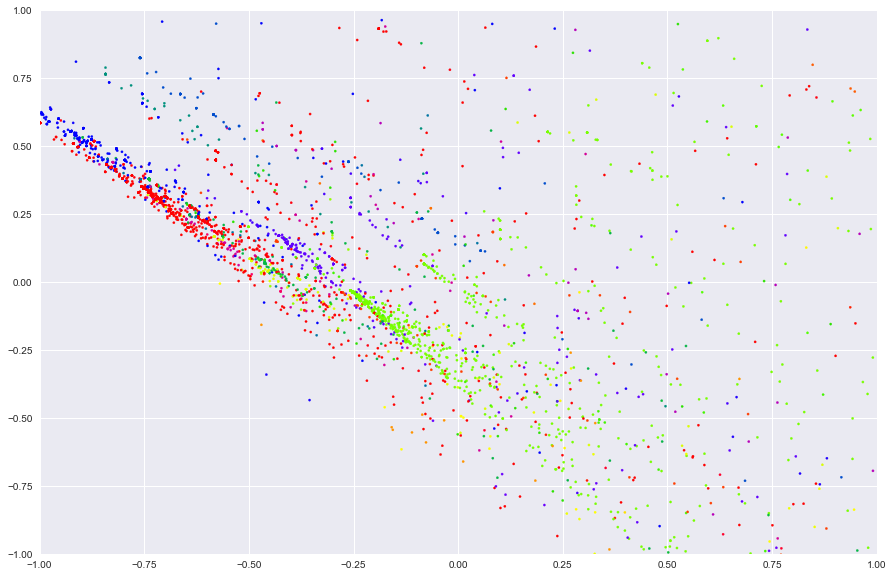

In [95]:
plt.figure(figsize=(15,10))
plt.scatter(pca[:, 0], pca[:, 1], c=kmeans.labels_,  s=5, cmap='prism');
plt.xlim((-1, 1))
plt.ylim((-1, 1));

In [96]:
cluster_sum,cluster_largest =[], []
range_n_clusters = range(5,150,5)
for n_clusters in tqdm(range_n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, max_iter=500, random_state=7).fit(kmeans_data_scaler) # kmeans_data_scaler!!
    cluster_pct = pd.Series(kmeans.labels_).value_counts()[:10]*100./(len(kmeans.labels_))
    cluster_sum.append( cluster_pct[cluster_pct>5].sum() )
    cluster_largest.append( cluster_pct.max() )

100%|██████████████████████████████████████████| 29/29 [01:08<00:00,  4.03s/it]


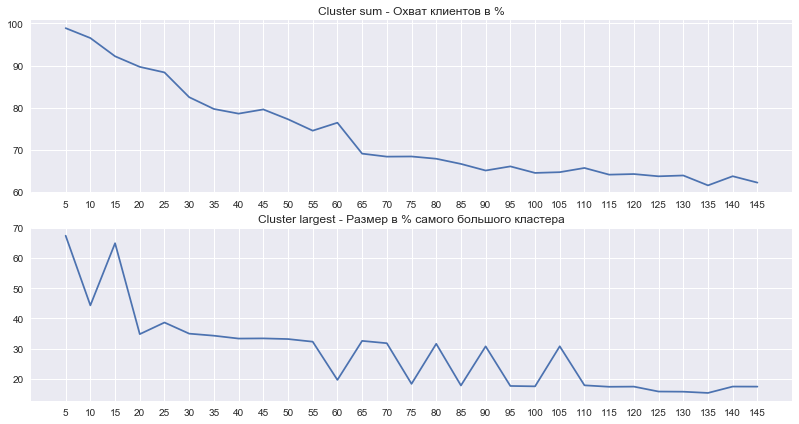

In [97]:
plt.figure(figsize=(30,7))
ax = plt.subplot(221)
ax.plot(cluster_sum);
plt.xticks(range(len(range_n_clusters)), range_n_clusters);
plt.title("Cluster sum - Охват клиентов в %");

ax = plt.subplot(223) 
ax.plot(cluster_largest);
plt.xticks(range(len(range_n_clusters)), range_n_clusters);
plt.title("Cluster largest - Размер в % самого большого кластера");

In [98]:
kmeans = KMeans(n_clusters=60, max_iter=500, random_state=7).fit(kmeans_data_scaler)
cluster_pct = pd.Series(kmeans.labels_).value_counts()[:10]*100./(len(kmeans.labels_))
cluster_pct

13    19.699946
5     18.467583
1     16.645830
49    16.502947
28     5.072334
0      3.143418
30     2.839793
43     2.053938
8      1.589570
3      1.518128
dtype: float64

In [99]:
cluster_pct[cluster_pct>5].sum()

76.38864082871942

Мы получили 5 кластеров более равномерных кластеров. При этом эти кластеры охватывают около 75% пользователей. Сохраним эту модель как финальную для этого подхода.

In [100]:
with open('kmeans_staked2.pkl', 'wb') as fp:
    pickle.dump(kmeans, fp)

**User2Vec**

In [34]:
import pickle
with open('data.pkl', 'rb') as f:
    data = pickle.load(f)

In [35]:
n_bin=5
u2v_features =['dropoff','pickup','status','payment_type','dayOfWeek_cat']

for features_ in data[['duration','distance','price']]:
    data['cat_'+ features_] = pd.qcut(data[features_][data[features_]!=0].apply(lambda x: np.log1p(x)),\
                                           n_bin, labels=False)
    u2v_features.append('cat_'+ features_)

In [36]:
data['cat_price'].value_counts()

1.0    15008
0.0    12726
3.0    12638
4.0    12610
2.0    10321
Name: cat_price, dtype: int64

In [37]:
def cat_duration_distance(x):
    if   x==0: x='very short'
    elif x==1: x='short'
    elif x==2: x='average'
    elif x==3: x='long'
    elif x==4: x='very long'   
    return x

def cat_price(x):
    if   x==0: x='very low'
    elif x==1: x='low'
    elif x==2: x='average'
    elif x==3: x='high'
    elif x==4: x='very high'  
    return x

In [38]:
data['cat_duration'].fillna('',inplace=True)
data['cat_distance'].fillna('',inplace=True)
data['cat_price'].fillna('',inplace=True)

In [39]:
data['cat_duration']  = data['cat_duration'].apply(lambda x: cat_duration_distance(x))
data['cat_distance']  = data['cat_distance'].apply(lambda x: cat_duration_distance(x))
data['cat_price']  = data['cat_price'].apply(lambda x: cat_price(x))

In [40]:
data['cat_price'].value_counts()

low          15008
very low     12726
high         12638
very high    12610
average      10321
              7072
Name: cat_price, dtype: int64

In [41]:
data[['dropoff','pickup','payment_type']] = data[['dropoff','pickup','payment_type']].\
                                            applymap(lambda x: ' '.join(x.split('_')))

In [42]:
def cat_time(x):
    #x=x.hour*100+ x.minute
    
    if       0<=x<=230: x='early morning'
    elif   230<x<=800: x='morning'
    elif  800<x<=1230: x='late morning'
    elif 1230<x<=1430: x='lunch'
    elif 1430<x<=1800: x='afternoon'
    elif 1800<x<=2000: x='end of working day'
    elif 2000<x<=2230: x='evening'
    elif 2230<x<=2400: x='night'        
    return x

In [43]:
data['cat_time']  = data['time'].apply(lambda x: cat_time(x))
u2v_features.append('cat_time')

In [44]:
data[u2v_features].head()

dropoff          pickup     status payment_type dayOfWeek_cat  \
0          secret  street address       done         card        sunday   
1          secret          secret  cancelled         card        sunday   
2          secret  street address       done         card        sunday   
3          secret  street address  cancelled         card        sunday   
4  street address  street address  cancelled         card        sunday   

  cat_duration cat_distance  cat_price       cat_time  
0   very short        short  very high  early morning  
1                                       early morning  
2      average      average  very high  early morning  
3                                       early morning  
4        short         long             early morning

In [45]:
data_u2v=pd.DataFrame()
data_u2v['user_id']=data['user_id']

In [46]:
data_u2v['order_txt']='order taxi from ' + data['pickup']+\
' to ' + data['dropoff']+\
' duration ' + data['cat_duration']+\
' distance ' + data['cat_distance']+\
' price ' + data['cat_price']+\
' time ' + data['cat_time']+\
' payment typet ' + data['payment_type']+\
' status order ' + data['status']

In [47]:
data_u2v = data_u2v.groupby(['user_id'])\
  .agg({'order_txt': lambda x: ' '.join(x)})

Добавим в полученный суммарный текст заказов клиента его персональные характеристики из users

In [48]:
data_u2v = data_u2v.merge(users, left_index=True, right_on='_id')
data_u2v.index=data_u2v['_id']
data_u2v['order_txt']='client ' + data_u2v['utm_medium']+\
                         ' os ' + data_u2v['app__os']+\
                           ' '  + data_u2v['order_txt']
data_u2v.drop(['_id','utm_medium','app__os'], axis=1,  inplace=True) 
data_u2v.head()

order_txt
_id                                                          
00100f0f3b  client cpi os iOS order taxi from street addre...
0015d74ca0  client invite os iOS order taxi from street ad...
0016e9f3f8  client invite os iOS order taxi from street ad...
001b9d8e6f  client organic os iOS order taxi from street a...
002bade505  client invite os iOS order taxi from street ad...

Используя готовое векторное представление слов в виде обученных по корпусу GoogleNews Word2Vec, представим каждый текст заказов по каждому клиенту в виде некоторого суммарного вектора слов 

In [49]:
import logging
logging.root.handlers = []  # Jupyter messes up logging so needs a reset
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
import gensim
from gensim.models import Word2Vec

2017-08-02 12:01:16,462 : WARNING : Slow version of gensim.models.doc2vec is being used
2017-08-02 12:01:16,605 : INFO : 'pattern' package not found; tag filters are not available for English


In [50]:
%%time 
wv = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz',binary=True,limit=500000)
wv.init_sims(replace=True)

2017-08-02 12:01:16,680 : INFO : loading projection weights from GoogleNews-vectors-negative300.bin.gz
2017-08-02 12:01:41,808 : INFO : loaded (500000, 300) matrix from GoogleNews-vectors-negative300.bin.gz
2017-08-02 12:01:41,811 : INFO : precomputing L2-norms of word weight vectors


Wall time: 30.2 s


In [51]:
wv.similar_by_word('taxi',topn=5)

[('taxis', 0.7733616828918457),
 ('cab', 0.7510559558868408),
 ('taxi_cab', 0.7403104901313782),
 ('taxicab', 0.7023347616195679),
 ('cabs', 0.6708043813705444)]

In [52]:
wv.similar_by_word('Uber',topn=10)

[('Über', 0.5201261043548584),
 ('über', 0.48257535696029663),
 ('uber', 0.4574912190437317),
 ('Thrillist', 0.41332197189331055),
 ('Aggro', 0.3993525505065918),
 ('Hipster', 0.3927866220474243),
 ('Ego', 0.38995158672332764),
 ('Pinko', 0.3894604742527008),
 ('Blond', 0.38883596658706665),
 ('AKA', 0.3882853388786316)]

In [53]:
import nltk
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue                  
            tokens.append(word)
    return tokens

In [54]:
%%time
data_u2v_tokenized = data_u2v['order_txt'].apply(lambda x: w2v_tokenize_text(x)).values

Wall time: 9.17 s


In [55]:
data_u2v_tokenized[:1]

array([ ['client', 'cpi', 'os', 'iOS', 'order', 'taxi', 'from', 'street', 'address', 'to', 'secret', 'duration', 'very', 'long', 'distance', 'very', 'long', 'price', 'very', 'high', 'time', 'lunch', 'payment', 'typet', 'card', 'status', 'order', 'done']], dtype=object)

In [56]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)
        # отдельно обработаем слова которых не было в словаре
        elif word.lower()=="cpi" :
            word="cost"
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)
    if not mean:
        #logging.warning("cannot compute similarity with no input %s", words)
        pass

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, review) for review in text_list ])    

In [57]:
%%time
# итоговое векторное представление текста заказа (текста, не одного слова)
data_u2v_tokenized = word_averaging_list(wv,data_u2v_tokenized)
del wv

Wall time: 4.06 s


Новое векторное представление каждого клиента

In [58]:
data_u2v_tokenized.max()

0.20213756

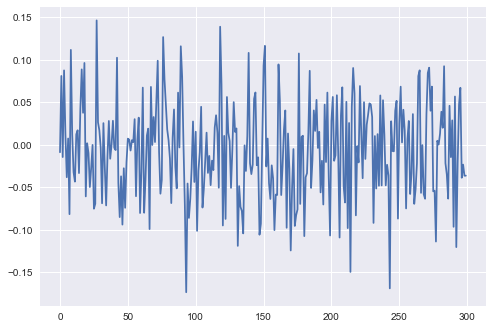

In [59]:
plot(data_u2v_tokenized[1]);

In [60]:
%%time
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# поскольку вектора уже нормализованы нет необходимости использовать tandardScaler
pca = PCA(n_components=2).fit_transform(data_u2v_tokenized)
print (pca.shape)

(5599, 2)
Wall time: 136 ms


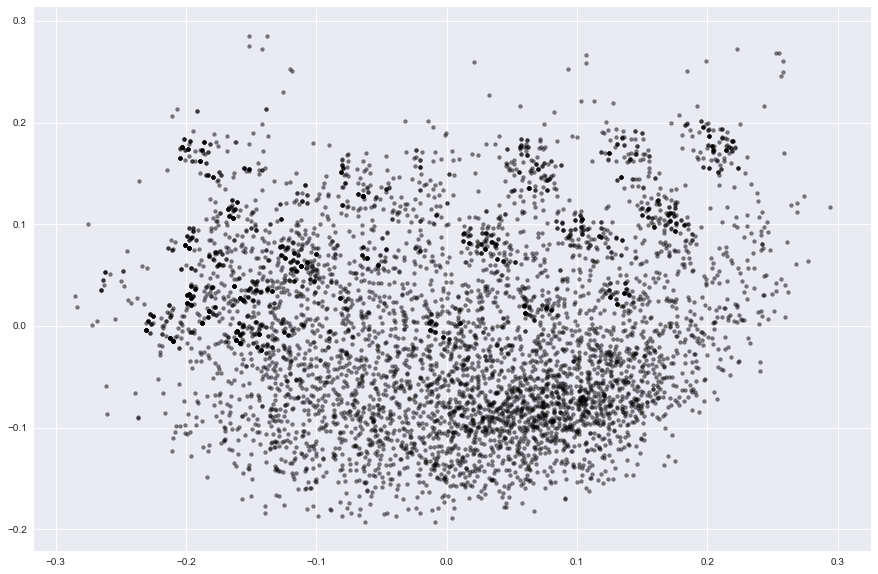

In [61]:
plt.figure(figsize=(15,10))
plt.scatter(pca[:, 0], pca[:, 1], s=15, c ='k',alpha=0.5);

In [64]:
%%time
hopkins(pd.DataFrame(data_u2v_tokenized)) # принимает объект DataFrame

100%|████████████████████████████████████████| 559/559 [00:16<00:00, 32.00it/s]


Wall time: 16.9 s


0.87893146434973957

Значение статистики Хопкинса показывающее степень наличия кластерной структуры на 0,10 меньше, чем для сырых данных

100%|██████████████████████████████████████████| 20/20 [02:18<00:00,  9.62s/it]


Wall time: 2min 18s


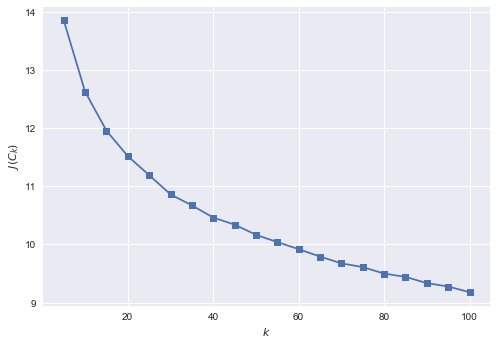

In [69]:
%%time
range_n_clusters = range(5,101,5)
inertia_claster(range_n_clusters, data_u2v_tokenized)

In [70]:
sample_size=5000
silhouette_avg_list,under_silhouette_avg_list = silhouette_cluster (sample_size,range_n_clusters, data_u2v_tokenized )

100%|██████████████████████████████████████████| 20/20 [02:49<00:00, 11.26s/it]


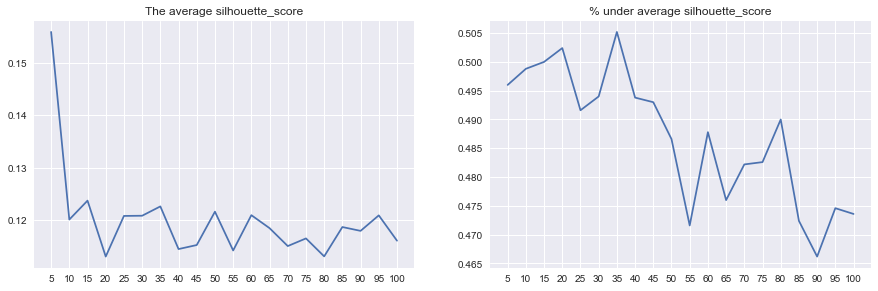

In [71]:
silhouette_plot(range_n_clusters, silhouette_avg_list, under_silhouette_avg_list)

In [117]:
kmeans = KMeans(n_clusters=15, max_iter=500, random_state=7).fit(data_u2v_tokenized)
cluster_pct = pd.Series(kmeans.labels_).value_counts()[:10]*100./(len(kmeans.labels_))
cluster_pct

4     12.930881
0      9.305233
7      8.412216
1      7.608502
6      7.376317
12     6.911949
5      6.751206
9      6.429720
10     6.126094
2      5.411681
dtype: float64

Значения, близкие к -1, соответствуют плохим (разрозненным) кластеризациям, значения, близкие к нулю, говорят о том, что кластеры пересекаются и накладываются друг на друга, значения, близкие к 1, соответствуют "плотным" четко выделенным кластерам.

В текущем представлении признаков  для кластеризации получены слабые значения коэффициента силуэта, что показывает  неустойчивость кластеризации

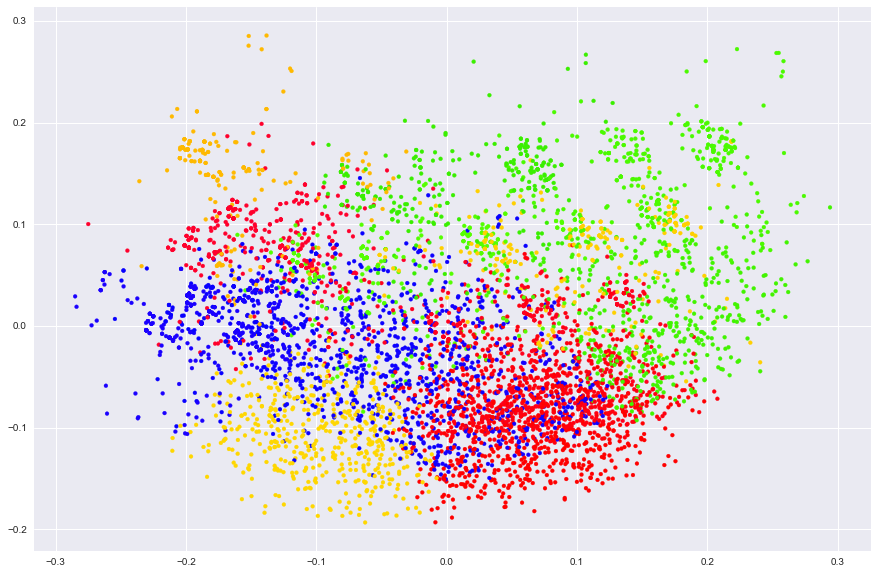

In [118]:
plt.figure(figsize=(15,10))
plt.scatter(pca[:, 0], pca[:, 1], c=kmeans.labels_,  s=15, cmap='prism');

Методы кластеризации основанные на плотности распределения объектов -  DBSCAN

In [93]:
%%time
from sklearn.cluster import DBSCAN
median_count_clasters, count_clasters, count_noisy, bigest_claster = [], [], [], []
for n in tqdm(range(2,51)):
    # применяем кластризацию pca
    db = DBSCAN(eps=0.01, min_samples=n, metric='euclidean',leaf_size=10).fit(pca)
    
    DBSCAN_labels = pd.Series(db.labels_)
    median_count_clasters.append(DBSCAN_labels.value_counts().median())
    count_clasters.append( len(DBSCAN_labels.value_counts()))
    count_noisy.append ( sum(DBSCAN_labels ==-1) )
    bigest_claster.append( DBSCAN_labels.value_counts().values[:1] )

100%|██████████████████████████████████████████████████| 49/49 [00:03<00:00, 14.63it/s]


Wall time: 3.35 s


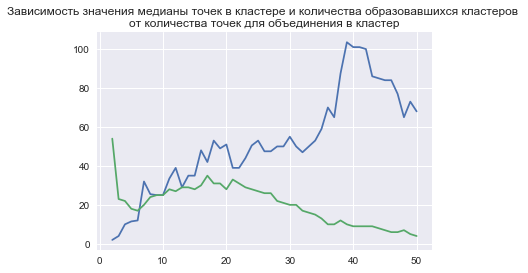

In [102]:
plot (range(2,51), median_count_clasters); 
plot (range(2,51), count_clasters);
plt.title("""Зависимость значения медианы точек в кластере и количества образовавшихся кластеров 
от количества точек для объединения в кластер""");

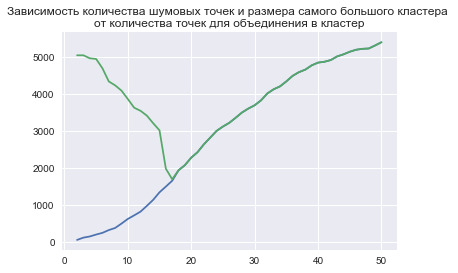

In [103]:
plot (range(2,51), count_noisy)
plot (range(2,51), bigest_claster)
plt.title("""Зависимость количества шумовых точек и размера самого большого кластера 
от количества точек для объединения в кластер""");

In [110]:
bigest_claster.index(min(bigest_claster))+2

17

Оптимальное число кластеров - 17

In [119]:
%%time
db = DBSCAN(eps=0.01, min_samples=17, metric='euclidean',leaf_size=10).fit(pca)
# Cluster labels for each point in the dataset given to fit(). Noisy samples are given the label -1
print (pd.Series(db.labels_).value_counts()[:5])

 2    1705
-1    1665
 1     451
 3     248
 9     131
dtype: int64
Wall time: 73.5 ms


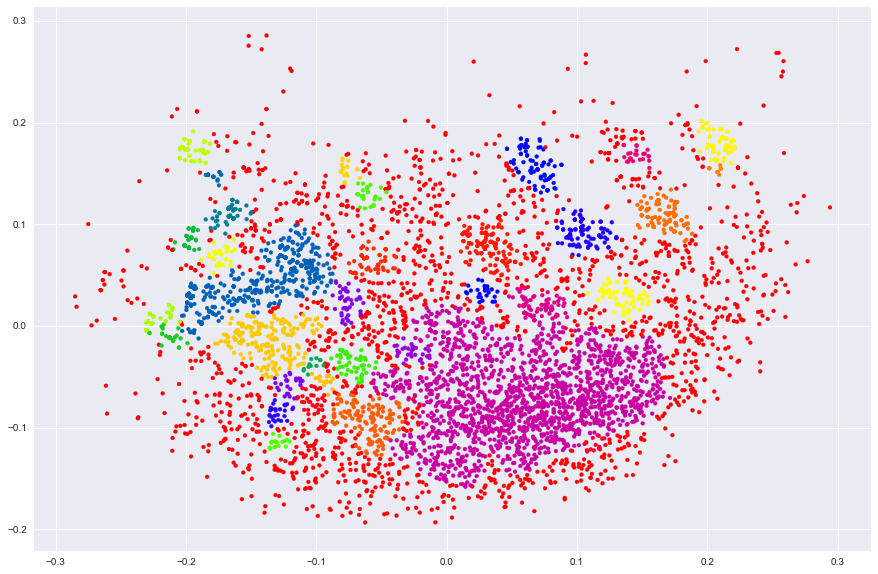

In [120]:
plt.figure(figsize=(15,10))
plt.scatter(pca[:, 0], pca[:, 1], c=db.labels_,  s=15, cmap='prism');
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

Отдельно все кластеры (зеленые) от шумовых точек (красные)

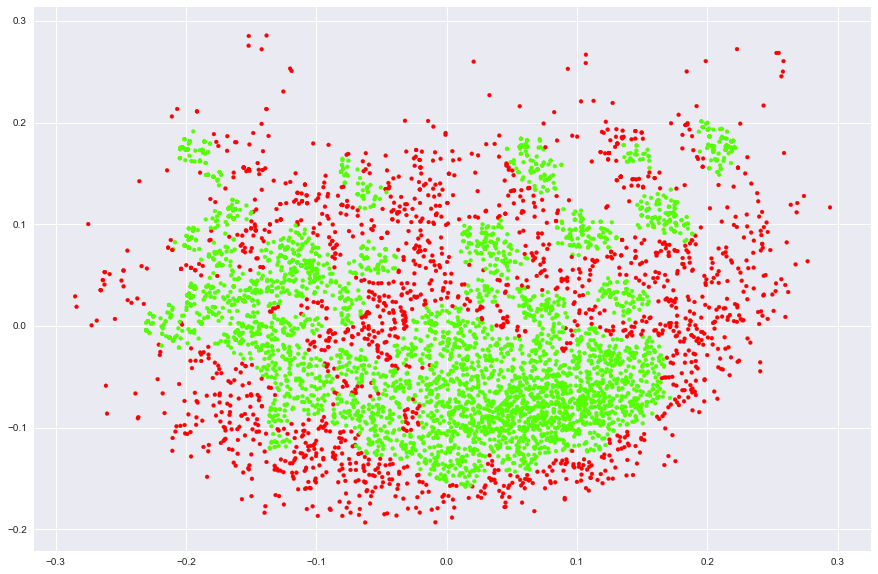

In [114]:
plt.figure(figsize=(15,10))
plt.scatter(pca[:, 0], pca[:, 1], c=db.labels_!=-1,  s=15, cmap='prism');

Посмотрим внутрь некоторых кластеров, чтобы попытаться понять почему их отобрал алгоритм

In [139]:
# https://stackoverflow.com/questions/36921951/truth-value-of-a-series-is-ambiguous-use-a-empty-a-bool-a-item-a-any-o/36922103
data_u2v['labels']=kmeans.labels_
# выберем интересующий нас вектор
number_cluster=4
data_number_cluster = data[data['user_id'].isin(data_u2v[data_u2v['labels']==number_cluster].index)]\
                          [['user_id']+ u2v_features]
data_number_cluster.shape

(30311, 10)

Сщхраним data_u2v которую будем использовать чтобы смотреть внутрь кластеров

In [73]:
with open('data_u2v.pkl', 'wb') as fp:
    pickle.dump(data_u2v, fp)

dropoff          pickup  count
0          secret  street address  22827
1          secret   street number   2836
2  street address  street address   1210
3          secret           store    552
4   street number  street address    473

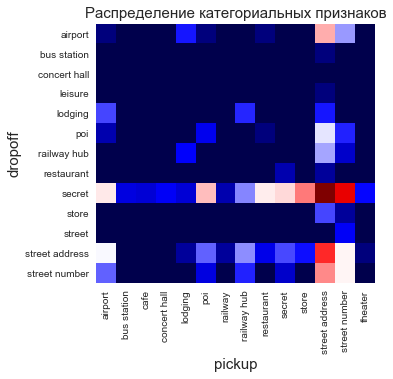

In [140]:
cat_imshow('pickup','dropoff',data_number_cluster)

cat_time cat_price  count
0  end of working day       low   1622
1  end of working day      high   1578
2           afternoon       low   1446
3             morning       low   1409
4  end of working day   average   1376

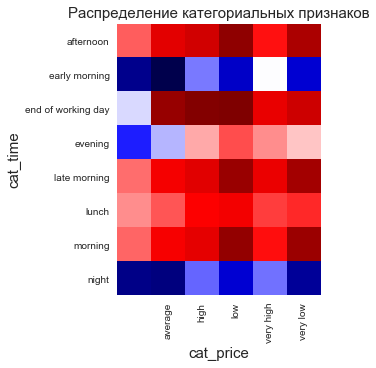

In [141]:
cat_imshow('cat_price','cat_time',data_number_cluster)

In [142]:
data_number_cluster=pd.get_dummies(data=data_number_cluster,columns=u2v_features) 
# u2v_features содержит только категориальные признаки приготовленные для User2Vec
data_number_cluster.shape

(30311, 67)

Таким образом кластер который охватывает порядка 1/3 клиентов покрывает половину  всех транзакций. 

Построим подобие эмбэдинга для кластера - вектор который будет отражать какой процент от каждого возможного значения категориальной переменной занимает выбранный кластер

In [143]:
data_number_cluster['count']=1
data_number_cluster = data_number_cluster.groupby(data_number_cluster['user_id']).sum()

vector_claster = data_number_cluster.iloc[:,:-1].div( data_number_cluster['count'].tolist(),axis='rows').sum()*100/\
len(set(data_number_cluster.index))
vector_claster[vector_claster>15]

dropoff_secret             86.536940
pickup_street address      85.397907
status_done                90.283055
payment_type_card          89.573784
dayOfWeek_cat_friday       21.126068
dayOfWeek_cat_saturday     16.593427
cat_duration_average       18.281139
cat_duration_long          15.029497
cat_duration_short         20.746969
cat_duration_very short    23.647921
cat_distance_average       16.514152
cat_distance_long          15.649992
cat_distance_short         22.461090
cat_distance_very short    23.417539
cat_price_average          15.160898
cat_price_high             16.500037
cat_price_low              24.157616
cat_price_very low         21.809709
cat_time_afternoon         20.959591
cat_time_late morning      18.876125
cat_time_morning           17.091858
dtype: float64

Подход User2Vec показал результат хуже, чем у Staked kMeans поскольку в текс был сгенерирован из категориальных признаков заказа. Наличие полноценных текстовых признаков (отзывы клиентов) могло бы увеличить качество кластеризации.

In [42]:
# лучше показать столбчатой диаграммой по каждому изначальному признаку в разрезе в % показать категориальные переменные

**RegSys**

Используем подход к кластеризации на основе рекомендательной системы. За аналог товарных единиц примем различные комбинации предметных наборов для клиента. Степень удовлетворенности клиента качеством сервиса / оказаной услуги будем считать суммарную стоимость заказов клиента по конкретному предметному набору в сравнении с другими клиентами.

In [146]:
data_rs = data[['credit','to_pay','vendor_id']+u2v_features] # 'user_id'
data_rs.head()

credit  to_pay vendor_id         dropoff          pickup     status  \
0     0.0     0.0         A          secret  street address       done   
1     0.0     0.0         B          secret          secret  cancelled   
2     0.0     0.0         A          secret  street address       done   
3     0.0     0.0         B          secret  street address  cancelled   
4     0.0     0.0         B  street address  street address  cancelled   

  payment_type dayOfWeek_cat cat_duration cat_distance  cat_price  \
0         card        sunday   very short        short  very high   
1         card        sunday                                        
2         card        sunday      average      average  very high   
3         card        sunday                                        
4         card        sunday        short         long              

        cat_time  
0  early morning  
1  early morning  
2  early morning  
3  early morning  
4  early morning

Необходимо категоризовать все числовые признаки, затем применить OneHotEncoder кодирование

In [147]:
data_rs['credit']  = data_rs['credit'].apply(lambda x: 'no bonus' if x==0 else 'use bonus' )
data_rs['to_pay']  = data_rs['to_pay'].apply(lambda x: 'no credit' if x==0 else 'use credit' )

data_rs[['cat_duration','cat_distance','cat_price']] = data_rs[['cat_duration','cat_distance','cat_price']].\
                                            applymap(lambda x: 'cancelled' if x=='' else x )
    
data_rs = pd.get_dummies(data=data_rs, columns=data_rs.columns) # [1:] для 'user_id'
# удалим пробелы в названиях столбцов - требование  SPMF
data_rs.columns = ['_'.join(x.split(' ')) for x in data_rs.columns]

Будем анализировать частые множества с помощью программы  SPMF - http://www.philippe-fournier-viger.com/spmf/

Для этого преобразуем таблицу к требуемому формату

In [148]:
%%time
data_sequence=pd.DataFrame()
data_sequence= data_rs.apply(lambda row : ' '.\
                          join([ str(coll) for coll, val in zip(range(len(data_rs.columns)),row) if val == 1]), axis=1)
print (data_sequence[1])

0 2 5 18 34 40 44 49 54 60 66 72
Wall time: 15.6 s


In [149]:
# запишем полученную Sequence Database в файл  .txt
data_sequence.to_csv('C:\\Users\\Pavel\\HW_HSE\\Wheely\\wheely.spmf.txt',\
                    header=False, index=False)

In [150]:
%%time
columns = data_rs.columns
data_sequence=pd.DataFrame()
data_sequence= data_rs.apply(lambda row : ' '.\
                        join([ columns[coll]+',' for coll, val in zip(range(len(data_rs.columns)),row) if val == 1]), axis=1)
print (data_sequence[1])

credit_no_bonus, to_pay_no_credit, vendor_id_B, dropoff_secret, pickup_secret, status_cancelled, payment_type_card, dayOfWeek_cat_sunday, cat_duration_cancelled, cat_distance_cancelled, cat_price_cancelled, cat_time_early_morning,
Wall time: 16.8 s


In [151]:
# запишем полученную Sequence Database в файл  .txt
data_sequence.to_csv('C:\\Users\\Pavel\\HW_HSE\\Wheely\\wheely.spmf_text.txt',\
                    header=False, index=False)

In [154]:
pd.set_option('max_colwidth', 800)
pd.set_option('display.large_repr', 'truncate')
pd.set_option('display.max_columns', 0)
pd.set_option('display.max_colwidth', -1)

Будем искать множества которые  реализуются не менее 5% от всех транзакций клиентов

In [163]:
!java -jar spmf.jar run FPGrowth_itemsets C:\Users\Pavel\HW_HSE\Wheely\wheely.spmf.txt \
                        FPGrowth_itemsets.out.txt 5.00%

>/C:/Users/Pavel/HW_HSE/Wheely/spmf.jar
=============  FP-GROWTH 0.96r19 - STATS =============
 Transactions count from database : 70375
 Max memory usage: 7.886421203613281 mb 
 Frequent itemsets count : 4954
 Total time ~ 556 ms


In [165]:
data_spmf = pd.read_csv('FPGrowth_itemsets.out.txt', sep='#SUP:',header=None, names=['Items','Support'])
data_spmf['Items'] = data_spmf['Items'].apply(lambda x : \
    ', '.join([columns[int(char)] for char in (x.split())]))

# рассмотрим различные наборы с наибольшими значениями уровня поддержки
data_spmf.sort(['Support'], ascending=False).reset_index(drop=True)[:10]

Items  Support
0  to_pay_no_credit                                70001  
1  credit_no_bonus                                 66975  
2  credit_no_bonus, to_pay_no_credit               66671  
3  status_done                                     62453  
4  to_pay_no_credit, status_done                   62093  
5  credit_no_bonus, status_done                    59134  
6  credit_no_bonus, to_pay_no_credit, status_done  58843  
7  pickup_street_address                           58048  
8  to_pay_no_credit, pickup_street_address         57730  
9  credit_no_bonus, pickup_street_address          55004

Чтобы частые множества содержали небольшое количество транзакций и были схожи с одинаковыми поразмеры кластерами необходимо  увеличить количество рубрик (Items) из которых будет складываться продуктовый ряд возможных заказов такси

In [166]:
# посмотрим  суммарное количество наборов каждой комбинации товаров(Count items) при заданом уровне поддерки
data_spmf['Count items']= data_spmf['Items'].apply(lambda x : len(x.split(',')))
data_spmf = data_spmf[data_spmf['Count items']>=7].reset_index(drop=True)#[:10]
data_spmf[-10:]

Items  Support  Count items
108  credit_no_bonus, to_pay_no_credit, vendor_id_B, pickup_street_address, status_done, payment_type_card, cat_time_morning        5100     7          
109  credit_no_bonus, to_pay_no_credit, vendor_id_A, pickup_street_address, status_done, payment_type_card, cat_price_low           3919     7          
110  credit_no_bonus, to_pay_no_credit, vendor_id_B, dropoff_secret, pickup_street_address, status_done, cat_price_low              4290     7          
111  credit_no_bonus, to_pay_no_credit, dropoff_secret, pickup_street_address, status_done, payment_type_card, cat_price_low        5597     7          
112  credit_no_bonus, to_pay_no_credit, vendor_id_B, pickup_street_address, status_done, payment_type_card, cat_price_low           5327     7          
113  credit_no_bonus, to_pay_no_credit, vendor_id_B, dropoff_secret, pickup_street_address, status_done, payment_type_invoice       5872     7          
114  credit_no_bonus, to_pay_no_credit, vendor_id_A, dropoff_street_address, pickup_street_address, status_done, payment_type_card  4203     7          
115  credit_no_bonus, to_pay_no_credit, vendor_id_B, dropoff_street_address, pickup_street_address, status_done, payment_type_card  6017     7          
116  credit_no_bonus, to_pay_no_credit, vendor_id_A, dropoff_secret, pickup_street_address, status_done, payment_type_card          9869     7          
117  credit_no_bonus, to_pay_no_credit, vendor_id_B, dropoff_secret, pickup_street_address, status_done, payment_type_card          10496    7

In [167]:
data_spmf.shape

(118, 3)

In [169]:
data_spmf[data_spmf['Support']<5000].shape

(88, 3)

In [171]:
# проверка правильности кода
sum(data_rs[ data_spmf['Items'][0].split(', ') ].sum(axis=1)==data_spmf['Count items'][0])

4017

In [172]:
data_spmf.reset_index(drop=True)

Items  Support  Count items
0    credit_no_bonus, to_pay_no_credit, dropoff_secret, status_cancelled, cat_duration_cancelled, cat_distance_cancelled, cat_price_cancelled                        4017     7          
1    credit_no_bonus, to_pay_no_credit, dropoff_secret, pickup_street_address, status_cancelled, cat_duration_cancelled, cat_distance_cancelled                      3735     7          
2    credit_no_bonus, to_pay_no_credit, pickup_street_address, status_cancelled, payment_type_card, cat_distance_cancelled, cat_price_cancelled                      3569     7          
3    credit_no_bonus, to_pay_no_credit, vendor_id_B, dropoff_secret, status_done, payment_type_invoice, cat_time_end_of_working_day                                  5784     7          
4    credit_no_bonus, to_pay_no_credit, vendor_id_B, pickup_street_address, status_done, payment_type_invoice, cat_time_end_of_working_day                           4171     7          
5    credit_no_bonus, to_pay_no_credit, vendor_id_B, dropoff_secret, pickup_street_address, status_done, cat_time_end_of_working_day                                 4098     7          
6    credit_no_bonus, to_pay_no_credit, vendor_id_A, pickup_street_address, status_done, payment_type_card, cat_time_afternoon                                       3568     7          
7    credit_no_bonus, to_pay_no_credit, dropoff_secret, pickup_street_address, status_done, payment_type_card, cat_time_afternoon                                    4790     7          
8    credit_no_bonus, to_pay_no_credit, vendor_id_B, pickup_street_address, status_done, payment_type_card, cat_time_afternoon                                       4096     7          
9    credit_no_bonus, to_pay_no_credit, vendor_id_A, pickup_street_address, status_done, payment_type_card, cat_price_very_high                                      4634     7          
10   credit_no_bonus, to_pay_no_credit, dropoff_secret, status_done, cat_duration_very_long, cat_distance_very_long, cat_price_very_high                             3773     7          
11   credit_no_bonus, to_pay_no_credit, vendor_id_B, status_done, cat_duration_very_long, cat_distance_very_long, cat_price_very_high                                4346     7          
12   credit_no_bonus, to_pay_no_credit, pickup_street_address, status_done, cat_duration_very_long, cat_distance_very_long, cat_price_very_high                      4479     7          
13   credit_no_bonus, to_pay_no_credit, vendor_id_B, status_done, payment_type_invoice, cat_duration_very_long, cat_price_very_high                                  3549     7          
14   credit_no_bonus, to_pay_no_credit, pickup_street_address, status_done, payment_type_card, cat_duration_very_long, cat_price_very_high                           3775     7          
15   credit_no_bonus, to_pay_no_credit, dropoff_secret, pickup_street_address, status_done, cat_duration_very_long, cat_price_very_high                              4058     7          
16   credit_no_bonus, to_pay_no_credit, vendor_id_A, pickup_street_address, status_done, payment_type_card, cat_price_high                                           4378     7          
17   credit_no_bonus, to_pay_no_credit, dropoff_secret, pickup_street_address, status_done, payment_type_card, cat_price_high                                        3665     7          
18   credit_no_bonus, to_pay_no_credit, vendor_id_B, pickup_street_address, status_done, cat_distance_short, cat_price_very_low                                      3704     7          
19   credit_no_bonus, to_pay_no_credit, vendor_id_B, dropoff_secret, status_done, cat_distance_very_short, cat_price_very_low                                        3900     7          
20   credit_no_bonus, to_pay_no_credit, pickup_street_address, payment_type_card, cat_duration_very_short, cat_distance_very_short, cat_price_very_low               3705     7          
21   credit_no_bonus, pickup_street_address, status_done, payment_

In [173]:
%%time
order_rs=pd.DataFrame()
for i in range(0,len(data_spmf)):   
    condition = data_rs[ data_spmf['Items'][i].split(', ') ].sum(axis=1)==data_spmf['Count items'][i]
    order_rs['order '+str(i)]= condition+0 # конвертация в число     

Wall time: 1.38 s


In [174]:
%%time
order_rs['user_id'] = data['user_id']
order_rs = order_rs.groupby(order_rs['user_id']).sum()

Wall time: 268 ms


In [176]:
# достаточно разряженная таблица возможно стоит приводит к плотному формату
order_rs.shape

(5599, 118)

In [177]:
with open('order_rs.pkl', 'wb') as fp:
    pickle.dump(order_rs, fp)

Для отображения на плотскость применим метод понижения размерности Truncated SVD (aka LSA).

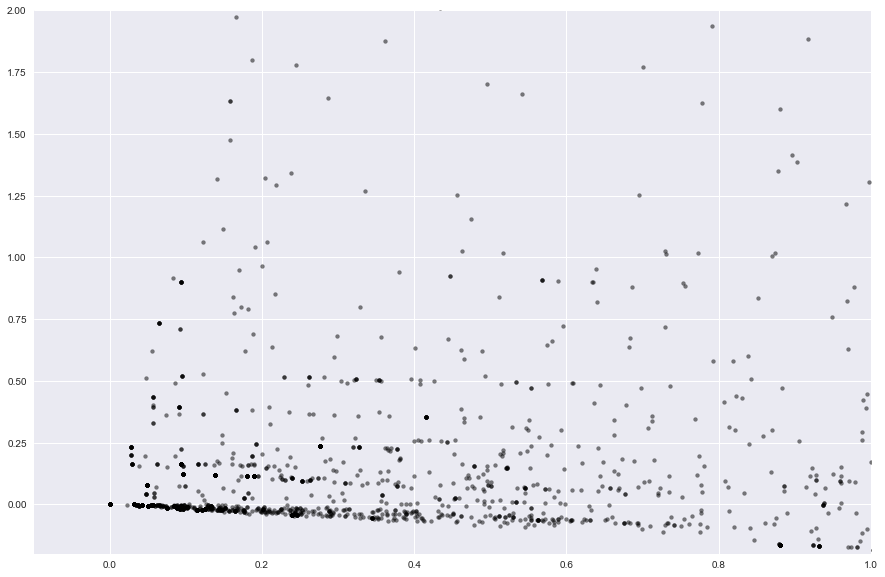

In [200]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=15, n_iter=100, random_state=7).fit_transform(order_rs)
plt.figure(figsize=(15,10))
plt.scatter(svd[:, 0], svd[:, 1], s=15, c ='k',alpha=0.5);
plt.xlim(-0.1,1)
plt.ylim(-0.2,2);

In [214]:
%%time
hopkins(order_rs) # принимает объект DataFrame

100%|████████████████████████████████████████████████| 559/559 [00:07<00:00, 73.66it/s]


Wall time: 7.72 s


0.99436727612672149

100%|██████████████████████████████████████████████████| 20/20 [00:52<00:00,  4.06s/it]


Wall time: 52.3 s


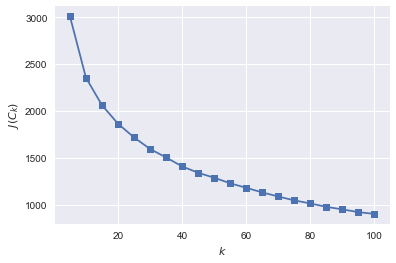

In [209]:
%%time
range_n_clusters = range(5,101,5)
inertia_claster(range_n_clusters, order_rs)

In [210]:
sample_size=5000
silhouette_avg_list,under_silhouette_avg_list = silhouette_cluster (sample_size,range_n_clusters, order_rs )

100%|██████████████████████████████████████████████████| 20/20 [01:43<00:00,  7.10s/it]


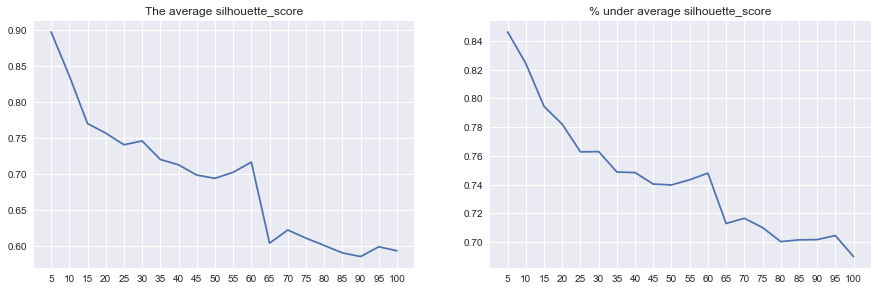

In [211]:
silhouette_plot(range_n_clusters, silhouette_avg_list, under_silhouette_avg_list)

In [213]:
kmeans = KMeans(n_clusters=30, max_iter=500, random_state=7).fit(order_rs)
cluster_pct = pd.Series(kmeans.labels_).value_counts()[:10]*100./(len(kmeans.labels_))
cluster_pct

0     88.372924
25    4.858010 
17    2.000357 
10    1.303804 
1     0.464369 
9     0.410788 
20    0.339346 
28    0.303626 
24    0.250045 
5     0.214324 
dtype: float64

Один кластер забирает все объеты датасета. По всей видимости категоризация всех числовых переменных даже при условии создания большого количества синтетических признаков не привело к обогащению данных.  Применим DBSCAN

In [221]:
%%time
from sklearn.cluster import DBSCAN
median_count_clasters, count_clasters, count_noisy, bigest_claster = [], [], [], []
for n in tqdm(range(2,51)):
    db = DBSCAN(eps=0.01, min_samples=n, metric='euclidean',leaf_size=10).fit(order_rs)
    
    DBSCAN_labels = pd.Series(db.labels_)
    median_count_clasters.append(DBSCAN_labels.value_counts().median())
    count_clasters.append( len(DBSCAN_labels.value_counts()))
    count_noisy.append ( sum(DBSCAN_labels ==-1) )
    bigest_claster.append( DBSCAN_labels.value_counts().values[:1] )

100%|██████████████████████████████████████████████████| 49/49 [13:41<00:00, 16.94s/it]


Wall time: 13min 41s


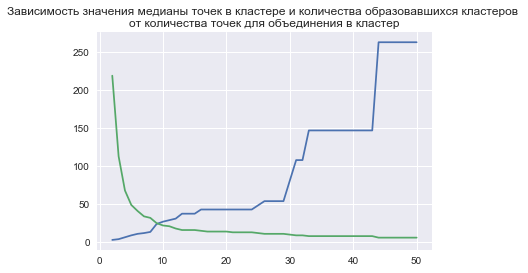

In [222]:
plot (range(2,51), median_count_clasters);
plot (range(2,51), count_clasters);
plt.title("""Зависимость значения медианы точек в кластере и количества образовавшихся кластеров 
от количества точек для объединения в кластер""");

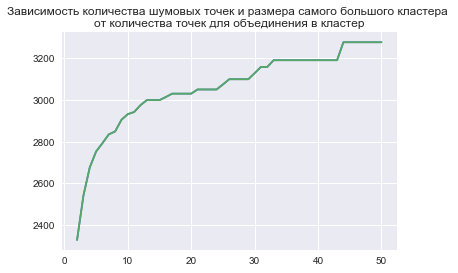

In [223]:
plot (range(2,51), count_noisy)
plot (range(2,51), bigest_claster)
plt.title("""Зависимость количества шумовых точек и размера самого большого кластера 
от количества точек для объединения в кластер""");

In [227]:
%%time
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.01, min_samples=9, metric='euclidean',leaf_size=10).fit(svd)
# Cluster labels for each point in the dataset given to fit(). Noisy samples are given the label -1
print (pd.Series(db.labels_).value_counts()[:5])

-1    2889
 0    1635
 1    340 
 3    186 
 2    108 
dtype: int64
Wall time: 446 ms


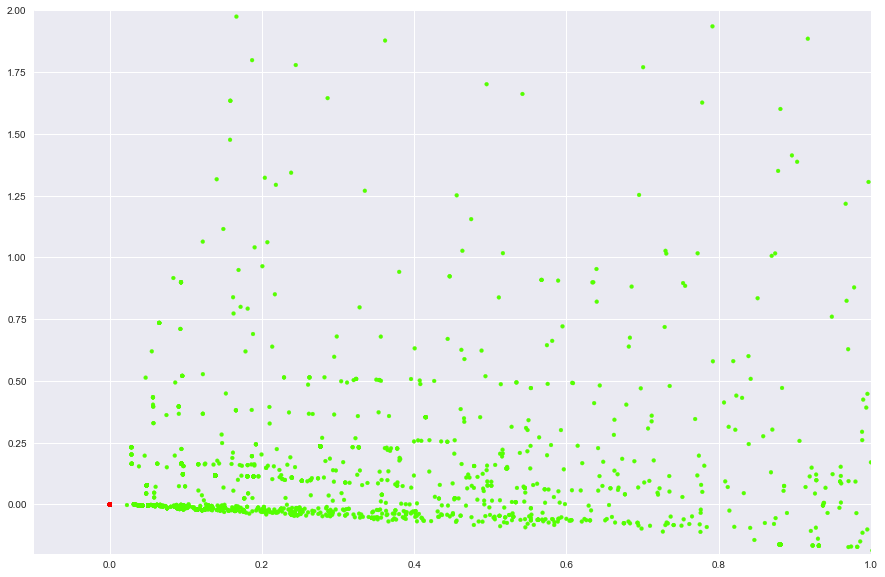

In [232]:
plt.figure(figsize=(15,10))
plt.scatter(svd[:, 0], svd[:, 1], c=db.labels_!=0,  s=15, cmap='prism');
plt.xlim(-0.1,1)
plt.ylim(-0.2,2);

Посмотрим внутрь некоторых кластеров, чтобы попытаться понять почему их отобрал алгоритм

In [233]:
order_rs['labels']=db.labels_
number_cluster=0
data_number_cluster = data[data['user_id'].isin(order_rs[order_rs['labels']==number_cluster].index)]

dropoff          pickup  count
0  street address  street address  821  
1  secret          street address  426  
2  street number   street address  239  
3  street number   street number   113  
4  poi             street address  100

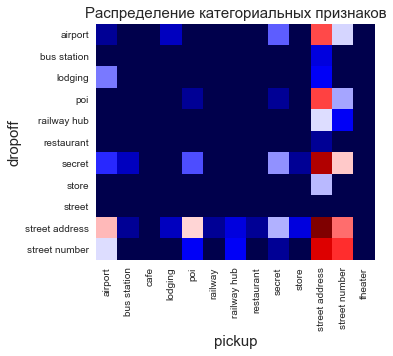

In [234]:
cat_imshow('pickup','dropoff',data_number_cluster)

cat_time cat_price  count
0  morning       average   131  
1  afternoon     average   129  
2  afternoon     high      127  
3  late morning  average   98   
4  afternoon     low       98

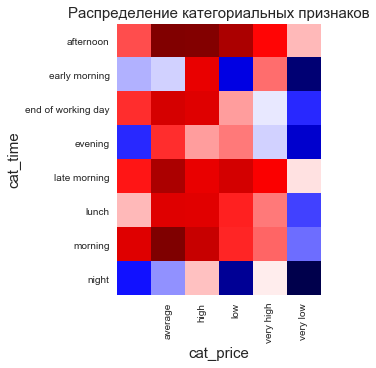

In [235]:
cat_imshow('cat_price','cat_time',data_number_cluster)

In [236]:
data_number_cluster_col = ['dropoff', 'pickup', 'status', 'payment_type', 'dayOfWeek_cat',\
                          'cat_duration', 'cat_distance', 'cat_price', 'cat_time']
data_number_cluster = data_number_cluster[data_number_cluster_col+ ['user_id']]
data_number_cluster=pd.get_dummies(data=data_number_cluster,columns=data_number_cluster_col) 
data_number_cluster['count']=1
data_number_cluster = data_number_cluster.groupby(data_number_cluster['user_id']).sum()

In [237]:
vector_claster = data_number_cluster.iloc[:,:-1].div( data_number_cluster['count'].tolist(),axis='rows').sum()*100/\
len(set(data_number_cluster.index))
vector_claster[vector_claster>15]

dropoff_secret            26.261064
dropoff_street address    44.205006
dropoff_street number     15.656791
pickup_street address     80.285933
status_done               87.266297
payment_type_card         92.212029
dayOfWeek_cat_friday      18.199759
dayOfWeek_cat_saturday    17.841562
cat_duration_average      26.922128
cat_duration_long         29.773761
cat_duration_short        19.229674
cat_duration_very long    15.574192
cat_distance_average      15.317168
cat_distance_long         38.231461
cat_distance_very long    25.733006
cat_price_average         27.233030
cat_price_high            24.069060
cat_price_low             17.280545
cat_price_very high       15.266741
cat_time_afternoon        22.438266
cat_time_late morning     17.175911
cat_time_morning          15.740345
dtype: float64

###  Часть 8. Финальная модель

**Staked kMeans**

 Модель Staked kMeans признана лучшей. Посмотрим что внутри кластеров первой модели

In [74]:
import pickle
with open('kmeans_staked2.pkl', 'rb') as f:
    kmeans = pickle.load(f)
with open('data_u2v.pkl', 'rb') as f:
    data_u2v = pickle.load(f)

In [76]:
cluster_pct = pd.Series(kmeans.labels_).value_counts()[:10]*100./(len(kmeans.labels_))
cluster_pct

13    19.699946
5     18.467583
1     16.645830
49    16.502947
28     5.072334
0      3.143418
30     2.839793
43     2.053938
8      1.589570
3      1.518128
dtype: float64

In [108]:
data_u2v['labels']=kmeans.labels_

def claster_inside(data,data_u2v,number_cluster):
    # выберем интересующий нас кластер
    cat_features = ['dropoff', 'pickup', 'status', 'payment_type', 'dayOfWeek_cat', 'cat_duration', \
                    'cat_distance', 'cat_price', 'cat_time']

    data_number_cluster = data[data['user_id'].isin(data_u2v[data_u2v['labels']==number_cluster].index)]\
                              [['user_id']+ cat_features]

    data_number_cluster=pd.get_dummies(data=data_number_cluster,columns=cat_features) 
    # u2v_features содержит только категориальные признаки приготовленные для User2Vec
    data_number_cluster['count']=1 # специальное поле для расчета
    #data_number_cluster.reset_index()
    data_number_cluster = data_number_cluster.groupby(data_number_cluster['user_id']).sum()

    vector_claster = data_number_cluster.iloc[:,:-1].div( data_number_cluster['count'].tolist(),axis='rows').sum()*100/\
    len(set(data_number_cluster.index))
    del data_number_cluster
    return vector_claster[vector_claster>20]

In [109]:
claster_inside(data,data_u2v,13)

dropoff_secret            45.421952
dropoff_street address    28.551239
pickup_street address     83.845532
status_done               84.001375
payment_type_card         88.751629
dayOfWeek_cat_friday      20.799059
cat_distance_very long    24.299570
cat_price_very high       22.260561
cat_time_afternoon        20.122206
dtype: float64

In [110]:
claster_inside(data,data_u2v,5)

dropoff_secret            38.752983
dropoff_street address    39.777329
pickup_street address     89.041692
status_done               82.614341
payment_type_card         99.129476
cat_duration_average      26.834600
cat_duration_long         21.389026
cat_duration_short        21.175012
cat_distance_average      24.487898
cat_distance_long         29.791053
cat_price_average         21.946327
cat_price_low             26.046546
cat_time_afternoon        24.071528
dtype: float64

In [111]:
claster_inside(data,data_u2v,1)

dropoff_secret            38.675088
dropoff_street address    31.489587
pickup_street address     85.271836
status_cancelled          24.725563
status_done               74.770931
payment_type_card         89.339290
cat_duration_short        21.550969
cat_price_                21.956932
cat_price_very low        21.274997
cat_time_afternoon        20.167289
dtype: float64

In [112]:
claster_inside(data,data_u2v,49)

dropoff_secret            33.018002
dropoff_street address    53.007588
pickup_street address     94.817896
status_done               89.044401
payment_type_card         99.945887
cat_duration_average      30.081979
cat_duration_short        25.998515
cat_distance_average      29.245814
cat_distance_long         29.127536
cat_price_average         21.046097
cat_price_low             33.969177
cat_time_afternoon        24.236773
dtype: float64

In [114]:
# также показать отличие кластера от среднего по набору данных

**User2Vec**

**RegSys**

Заметно, что последние две модели сваливают всех клиентов в примерно один и тот же кластер